In [ ]:
#-------------------------------------------------------------
#--- HAMRO DEEP ATLAS KO ORG CODE (Unet,Unet)
#-------------------------------------------------------------
#--- VoxelMorph
#--- Alpha tune
#-------------------------------------------------------------

# Specifying PC or laptop

In [2]:
#-------------------------------------------------------------
#--- Asking Prafulla if he wants to use RIU PC or Local Laptop
#-------------------------------------------------------------
x = input("0: Using RIU PC\n1: Using Local Laptop")

#-------------------------------------------------------------
#--- Error Handling
#-------------------------------------------------------------
if x != '0' and x != '1':

    # Try importing requests, install if not available
    try:
        import requests
    except ImportError:
        ! pip install requests
        import requests
    
    # printing error message
    print("\033[91m" + "😂😭😂 ERROR GENIOUS ERROR 😂😭😂" + "\033[0m")
    
    # imports
    from PIL import Image
    from io import BytesIO
    from IPython.display import display

    # URL of the image
    url = "https://i.pinimg.com/736x/4f/f9/9b/4ff99b4b0401e3f3fba6f3aa0ea81ef6.jpg"

    # Get image data from URL
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    
    # Display the image
    display(img)

    # Kill the kernel
    exit()

## IMPORT SECTION

In [3]:
#-------------------------------------------------------------
#--- Importing essential libraries and functions
#-------------------------------------------------------------

try:
    # Importing essential libraries
    import monai
    import torch
    import itk
    import numpy as np
    import matplotlib.pyplot as plt
    import random
    import glob
    import os.path
    import tempfile
    from monai.transforms import LoadImage
    from monai.metrics import DiceMetric
    from torch.nn.functional import one_hot

    # Importing utility functions from utils.py
    from utils import (
        preview_image,
        preview_3D_vector_field,
        preview_3D_deformation,
        jacobian_determinant,
        plot_against_epoch_numbers,
    )

except ImportError as e:
    print("Importing error:",e)

In [4]:
#-------------------------------------------------------------
#--- ASSIGNING DEVICE
#-------------------------------------------------------------

def get_device():

    if torch.cuda.is_available():
        device = torch.device("cuda:0")
        print("CUDA is available.")
        print("GPU:", torch.cuda.get_device_name(0)) # Prints the GPU name
    else:
        device = torch.device("cpu")
        print("CUDA not available. Using CPU.")
    print("Using device:", device)
    return device

# Implementation of the above function
device = get_device()

CUDA is available.
GPU: NVIDIA GeForce RTX 3070 Laptop GPU
Using device: cuda:0


In [5]:
#-------------------------------------------------------------
#--- CHECKING MONAI CONFIGURATION
#-------------------------------------------------------------

def configure_environment(seed=100):

    # Set reproducibility
    monai.utils.set_determinism(seed=seed)
    print(f"Deterministic seed set to {seed}")

    # Disable ITK warnings
    itk.ProcessObject.SetGlobalWarningDisplay(False)

    # Disable TF32 for consistency
    torch.backends.cuda.matmul.allow_tf32 = False
    torch.backends.cudnn.allow_tf32 = False

    # Print MONAI config
    monai.config.print_config()

    # Enable inline plotting if in Jupyter
    try:
        get_ipython()
        from IPython import get_ipython
        get_ipython().run_line_magic("matplotlib", "inline")
        print("Notebook detected: Enabled %matplotlib inline")
    except Exception:
        pass

# Implementation of above function
configure_environment()

Deterministic seed set to 100
MONAI version: 1.5.0
Numpy version: 2.1.2
Pytorch version: 2.5.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: d388d1c6fec8cb3a0eebee5b5a0b9776ca59ca83
MONAI __file__: c:\Users\<username>\OneDrive\Desktop\ChoorneSoch\sarpa\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.4.4
Nibabel version: 5.3.2
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
scipy version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 11.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.20.1+cu121
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 7.0.0
pandas version: NOT INSTALLED or UNKNOWN VERSION.
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTAL

In [6]:
#-------------------------------------------------------------
#--- HYPERPARAMETERS SETTINGS
#-------------------------------------------------------------

if x == '0':
    resize = (256, 128, 256)
else:
    resize = (96, 96, 96)

#-------------------------------------------------------------
#--- ASSIGNING PATHS
#-------------------------------------------------------------

if x == '0':
    image_paths = glob.glob(r"C:\DeepAtlas\OASIS_root\IBSR_Img\IBSR_*.nii")
    segmentation_paths = glob.glob(r"C:\DeepAtlas\OASIS_root\IBSR_Mask\IBSR_*.nii")
else:
    image_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_*.nii")
    segmentation_paths = glob.glob(r"C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Mask\IBSR_*.nii")

print(image_paths)
print(len(image_paths),"\n")

print(segmentation_paths)
print(len(segmentation_paths),"\n")

['C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_01.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_02.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_03.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_04.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_05.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_06.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_07.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_08.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_09.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_10.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_11.nii', 'C:\\Users\\Praful\\OneDrive\\D

In [7]:
#-------------------------------------------------------------
#--- RESIZING AND ASSUMING FIX NUMBER OF SEGMENTS
#-------------------------------------------------------------

num_segmentation_classes = 4  # background, CSF, white matter, gray matter

#-------------------------------------------------------------
# Defining segmentation IDs to select
#-------------------------------------------------------------
# For 18
selected_seg_ids = ["IBSR_01.nii","IBSR_02.nii","IBSR_04.nii","IBSR_05.nii","IBSR_08.nii","IBSR_09.nii", "IBSR_10.nii", "IBSR_11.nii", "IBSR_14.nii","IBSR_15.nii","IBSR_16.nii","IBSR_17.nii","IBSR_18.nii" ]
# For 20
# selected_seg_ids = ["IBSR_01.nii","IBSR_02.nii","IBSR_03.nii","IBSR_04.nii","IBSR_05.nii","IBSR_06.nii", "IBSR_08.nii", "IBSR_10.nii", "IBSR_11.nii","IBSR_14.nii","IBSR_15.nii","IBSR_16.nii","IBSR_18.nii", "IBSR_19.nii", "IBSR_20.nii"]

#-------------------------------------------------------------
# Filter segmentation_paths to include only selected_seg_ids (exact match)
#-------------------------------------------------------------
filtered_segmentation_paths = []

for path in segmentation_paths:
    filename = os.path.basename(path)  # extract IBSR_xx.nii
    if filename in selected_seg_ids:
        filtered_segmentation_paths.append(path)

segmentation_paths = filtered_segmentation_paths

#-------------------------------------------------------------
# Checking the filtered segmentation paths
#-------------------------------------------------------------
print(segmentation_paths)
print(len(segmentation_paths),"\n")

['C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_01.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_02.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_04.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_05.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_08.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_09.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_10.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_11.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_14.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_15.nii', 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_16.nii', 'C:\\Users\\Praful\\

In [8]:
#-------------------------------------------------------------
#--- EXTRACTING IMG AND SEG IDs
#-------------------------------------------------------------

# Function to extract the image ID from the file path
def path_to_id(path):
    return "_".join(os.path.basename(path).split("_")[:2])

seg_ids = list(map(path_to_id, segmentation_paths))
print("SEG ID:\n",seg_ids,"\n")

#-------------------------------------------------------------
#--- Creating image IDs as a list to avoid map exhaustion
#-------------------------------------------------------------
img_ids = list(map(path_to_id, image_paths))
print("IMG ID:\n",list(img_ids),"\n")


SEG ID:
 ['IBSR_01.nii', 'IBSR_02.nii', 'IBSR_04.nii', 'IBSR_05.nii', 'IBSR_08.nii', 'IBSR_09.nii', 'IBSR_10.nii', 'IBSR_11.nii', 'IBSR_14.nii', 'IBSR_15.nii', 'IBSR_16.nii', 'IBSR_17.nii', 'IBSR_18.nii'] 

IMG ID:
 ['IBSR_01.nii', 'IBSR_02.nii', 'IBSR_03.nii', 'IBSR_04.nii', 'IBSR_05.nii', 'IBSR_06.nii', 'IBSR_07.nii', 'IBSR_08.nii', 'IBSR_09.nii', 'IBSR_10.nii', 'IBSR_11.nii', 'IBSR_12.nii', 'IBSR_13.nii', 'IBSR_14.nii', 'IBSR_15.nii', 'IBSR_16.nii', 'IBSR_17.nii', 'IBSR_18.nii'] 



In [9]:
#-------------------------------------------------------------
#--- Creating a list of dictionaries for images and segmentations
#-------------------------------------------------------------

data = []
for img_index, img_id in enumerate(img_ids):
    data_item = {"img": image_paths[img_index]} # Create a dictionary with the image file path
    if img_id in seg_ids: # Check if this image has a corresponding segmentation file
        data_item["seg"] = segmentation_paths[seg_ids.index(img_id)] # Add segmentation file path to the dictionary
    data.append(data_item) # Add this dictionary to the data list

#-------------------------------------------------------------
# Print total images and segmentations
#-------------------------------------------------------------
print("Total images:", len(data))

# Count how many entries have segmentations
num_segs = sum(1 for item in data if "seg" in item)
print("Total segmentations:", num_segs, "\n")

#-------------------------------------------------------------
# Splitting into segmentation available and not available data
#-------------------------------------------------------------

# Filters data to keep only entries that contain a segmentation path.
data_seg_available = list(filter(lambda d: "seg" in d.keys(), data))

# Filters data to keep entries that only have an image (no "seg" key).
data_seg_unavailable = list(filter(lambda d: "seg" not in d.keys(), data))

#-------------------------------------------------------------
# Checking the number of entries with and without segmentation
#-------------------------------------------------------------
print("Number of entries with segmentation available:", len(data_seg_available))
print("Number of entries without segmentation available:", len(data_seg_unavailable))

#-------------------------------------------------------------
#--- Splitting the dataset
#-------------------------------------------------------------
# For 18
test_ids = ["IBSR_05.nii", "IBSR_15.nii", "IBSR_17.nii"]
# For 20
# test_ids = ["IBSR_05.nii", "IBSR_06.nii", "IBSR_15.nii", "IBSR_19.nii"]
data_seg_available_train = []
data_seg_available_valid = []

for img_index, img_id in enumerate(img_ids):
    data_item = {"img": image_paths[img_index]} # Create a dictionary with the image file path
    if img_id in seg_ids: # Check if this image has a corresponding segmentation file
        data_item["seg"] = segmentation_paths[seg_ids.index(img_id)] # Add segmentation file path to the dictionary
        if img_id in test_ids:
            data_seg_available_valid.append(data_item)
            continue
        data_seg_available_train.append(data_item)

# Validation of the segmentation network only makes sense if you have enough segmentation labels.
# E.g. definitely skip validation here if there's just one segmentation label.

print("Total data items:", len(data))
print("Number of training items (with/without segmentation):", len(data_seg_available_train))
print("Number of validation items (with/without segmentation):", len(data_seg_available_valid))
print(data_seg_available_train)
print(data_seg_available_valid)


Total images: 18
Total segmentations: 13 

Number of entries with segmentation available: 13
Number of entries without segmentation available: 5
Total data items: 18
Number of training items (with/without segmentation): 10
Number of validation items (with/without segmentation): 3
[{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_01.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_01.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_02.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_02.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_04.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_04.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_08.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Deskto

In [10]:
#-------------------------------------------------------------
#--- STUDING DATA
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- STUDYING DATA")
print("#-------------------------------------------------------------\n")

from monai.transforms import LoadImage
import torch

# Initialize the loader
loader = LoadImage(image_only=True)

# Loop over each item in your data list
for idx, item in enumerate(data):
    print(f"\nIBSR: {idx+1}")

    # Load and print the shape of the image
    img_tensor = loader(item["img"])
    print(f"Image path: {item['img']}")
    print(f"Image shape (torch tensor): {img_tensor.shape}")

    # Load and print the shape of the segmentation if it exists
    if "seg" in item:
        seg_tensor = loader(item["seg"])
        print(f"Segmentation path: {item['seg']}")
        print(f"Segmentation shape (torch tensor): {seg_tensor.shape}")



#-------------------------------------------------------------
#--- STUDYING DATA
#-------------------------------------------------------------


IBSR: 1
Image path: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_01.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Mask\IBSR_01.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

IBSR: 2
Image path: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_02.nii
Image shape (torch tensor): torch.Size([256, 128, 256])
Segmentation path: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Mask\IBSR_02.nii
Segmentation shape (torch tensor): torch.Size([256, 128, 256, 1])

IBSR: 3
Image path: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_03.nii
Image shape (torch tensor): torch.Size([256, 128, 256])

IBSR: 4
Image path: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch


#-------------------------------------------------------------
#--- VISUALIZING DATA
#-------------------------------------------------------------



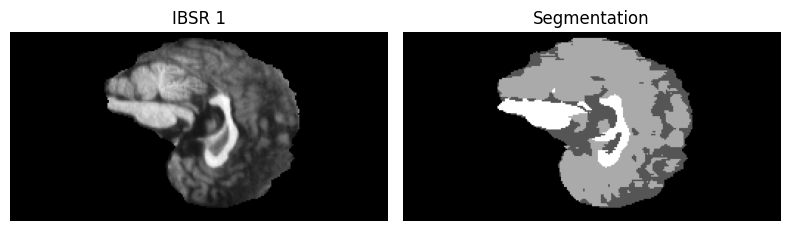

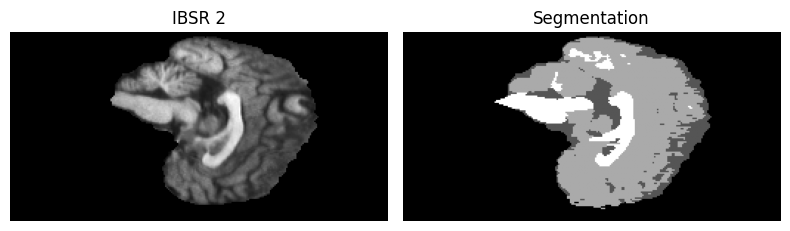

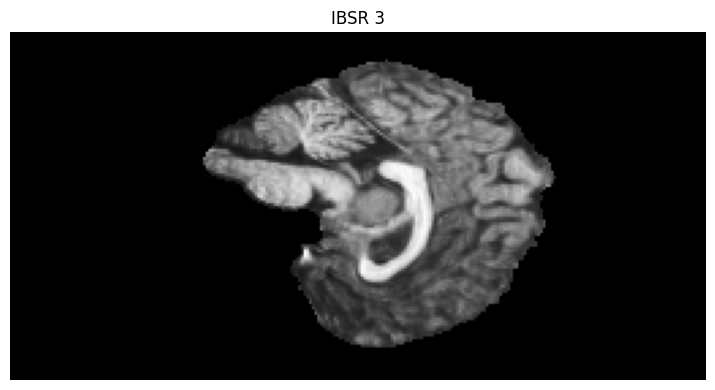

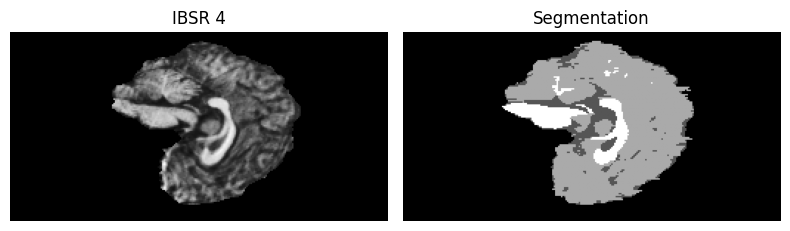

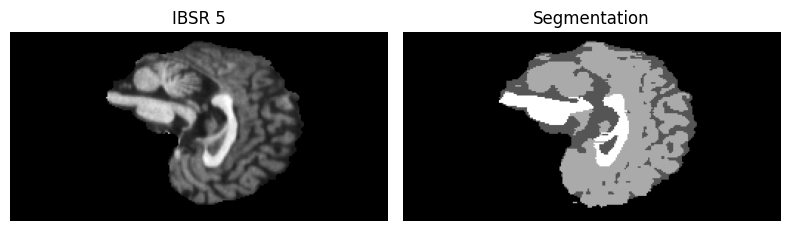

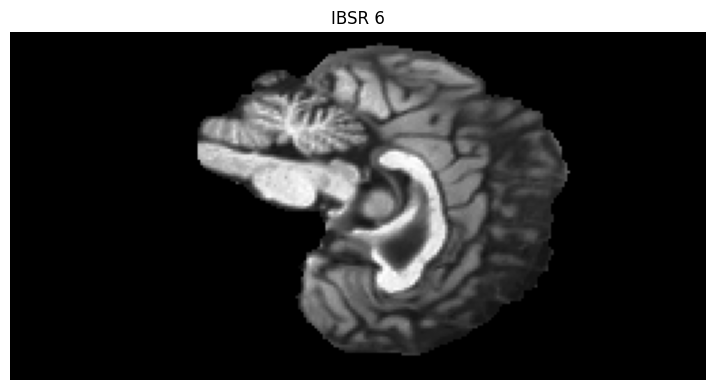

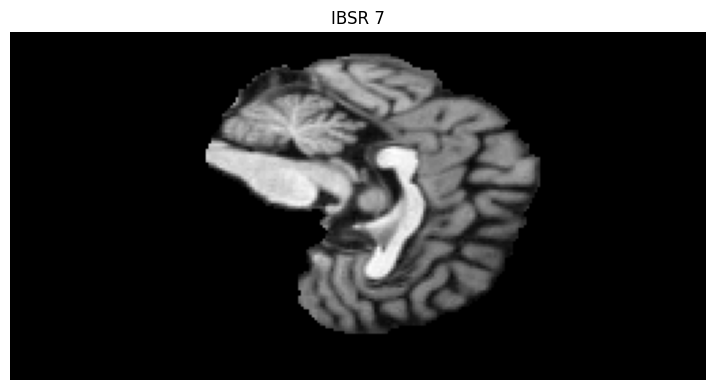

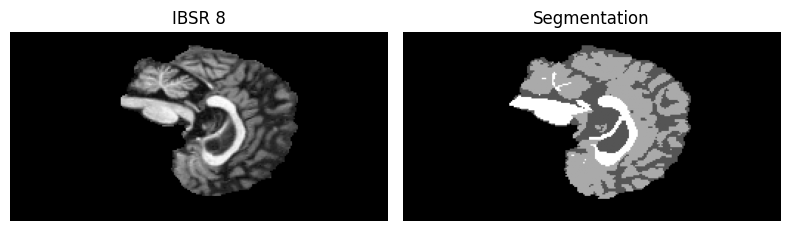

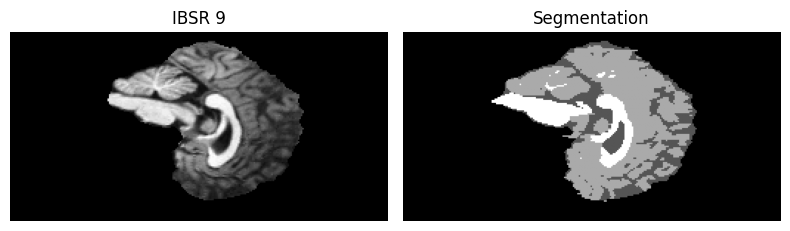

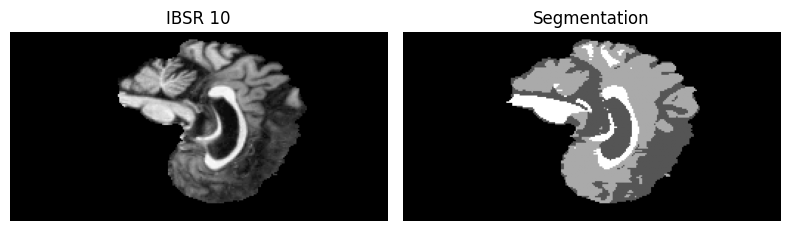

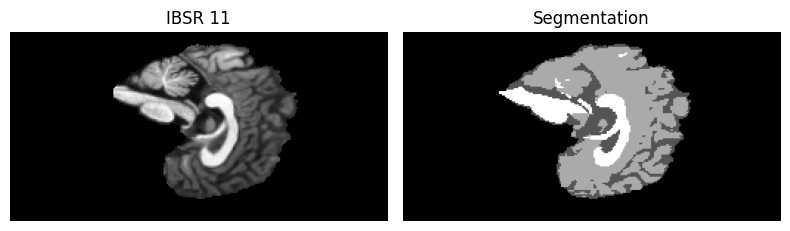

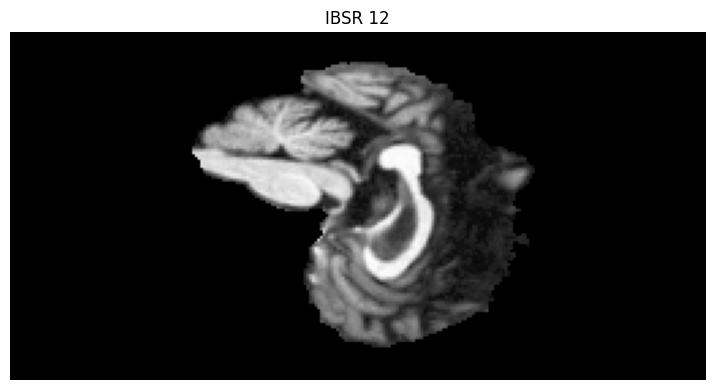

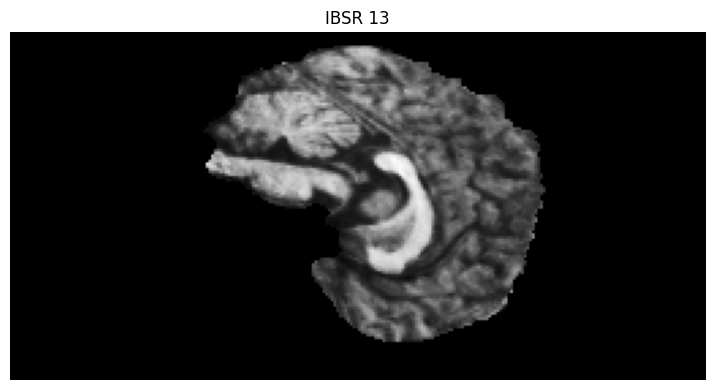

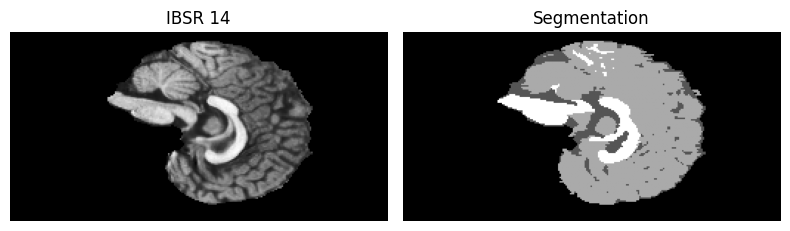

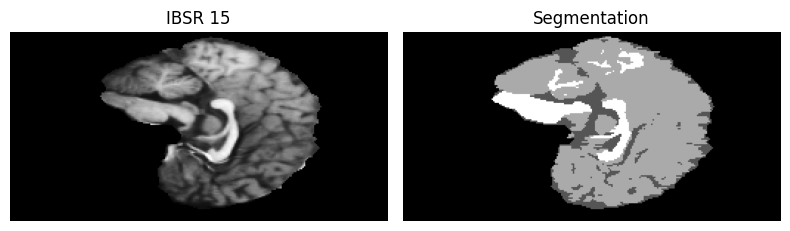

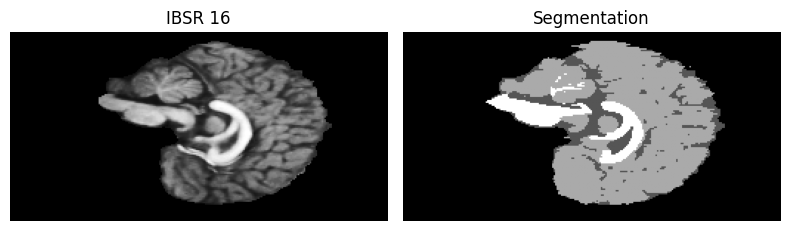

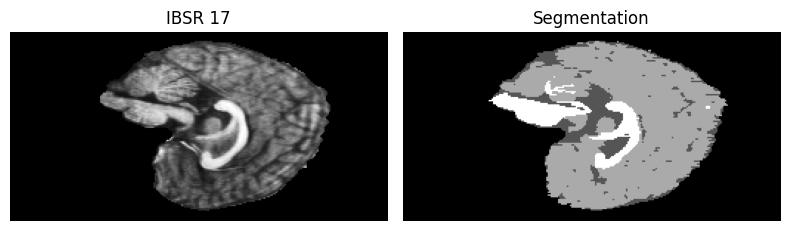

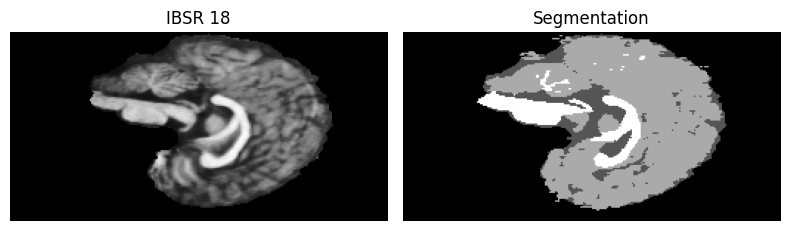

In [11]:
#-------------------------------------------------------------
#--- VISUALIZING DATA
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- VISUALIZING DATA")
print("#-------------------------------------------------------------\n")

import matplotlib.pyplot as plt
from monai.transforms import LoadImage

# Loader to convert filepath to array
loader = LoadImage(image_only=True)

for i, item in enumerate(data):
    img = loader(item["img"])
    
    has_seg = "seg" in item
    fig, axs = plt.subplots(1, 2 if has_seg else 1, figsize=(8, 4))
    
    # Ensure axs is always a list for uniform access
    if not has_seg:
        axs = [axs]
    
    # Display the image (middle slice)
    axs[0].imshow(img[img.shape[0] // 2], cmap='gray')
    axs[0].set_title(f"IBSR {i+1}")
    axs[0].axis('off')

    # If segmentation exists, display it too
    if has_seg:
        seg = loader(item["seg"])
        axs[1].imshow(seg[seg.shape[0] // 2], cmap='gray')
        axs[1].set_title("Segmentation")
        axs[1].axis('off')

    plt.tight_layout()
    plt.show()



#-------------------------------------------------------------
#--- DISPLAYING RANDOM IMAGE
#-------------------------------------------------------------



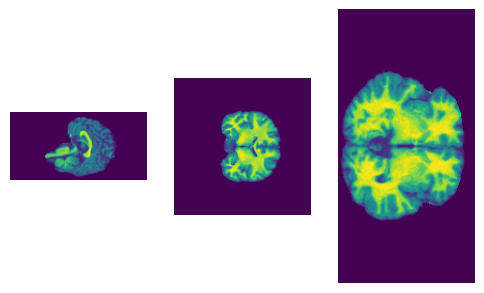

In [12]:
#-------------------------------------------------------------
#--- DISPLAYING RANDOM IMAGE
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DISPLAYING RANDOM IMAGE")
print("#-------------------------------------------------------------\n")

data_item = random.choice(data)
preview_image(monai.transforms.LoadImage(image_only=True)(data_item['img']), figsize=(6,6), normalize_by="slice")

In [13]:
#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- APPLYING PREPROCESSING TRANSFORMATION")
print("#-------------------------------------------------------------\n")

# set of preprocessing transformations
transform_seg_available = monai.transforms.Compose(
    transforms = [
        monai.transforms.LoadImageD(keys=["img", "seg"], image_only=True),
        monai.transforms.EnsureChannelFirstD(keys=["img", "seg"]),
        monai.transforms.EnsureTypeD(keys=["img", "seg"]),
        monai.transforms.TransposeD(keys=["img", "seg"], indices=(0,1,2,3)),
        (
            monai.transforms.ResizeD(
                keys=["img", "seg"],
                spatial_size=resize,
                mode=["trilinear", "nearest"],
                align_corners=[False, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

dataset_seg_available_train = monai.data.CacheDataset(
    data=data_seg_available_train, transform=transform_seg_available, cache_num=4 # 16
)

dataset_seg_available_valid = monai.data.CacheDataset(
    data=data_seg_available_valid, transform=transform_seg_available, cache_num=4 # 16
)


#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------



Loading dataset: 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]



#-------------------------------------------------------------
#--- PREVIEW RANDOM IMAGE
#-------------------------------------------------------------



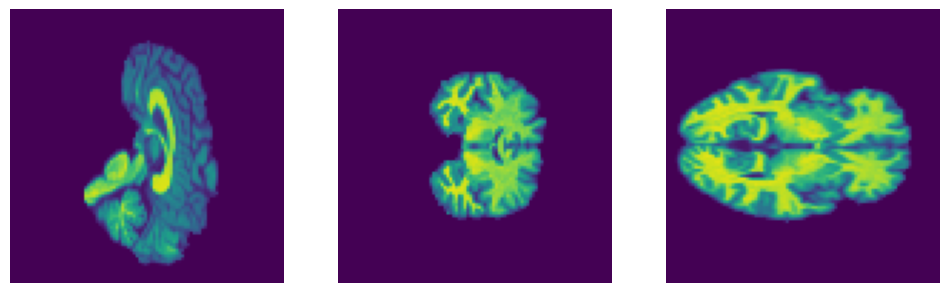

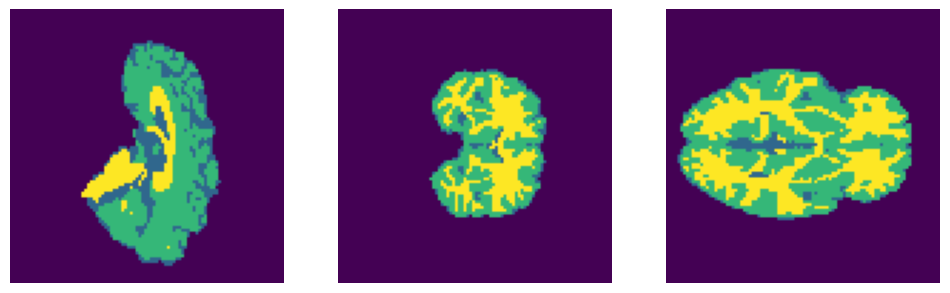

In [14]:
#-------------------------------------------------------------
#--- PREVIEW RANDOM IMAGE
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- PREVIEW RANDOM IMAGE")
print("#-------------------------------------------------------------\n")

data_item = transform_seg_available(random.choice(data_seg_available))

preview_image(data_item['img'][0])
preview_image(data_item['seg'][0])

In [15]:
#-------------------------------------------------------------
#--- CHECKING THE SHAPE OF LOADED SEG MASK
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- CHECKING THE SHAPE OF LOADED SEG MASK")
print("#-------------------------------------------------------------\n")

from monai.transforms import LoadImage

# Set up the loader
loader = LoadImage(image_only=True)

# Print the shape of all loaded segmentation masks
def print_all_seg_shapes(data):
    for i, data_item in enumerate(data):
        if "seg" in data_item:
            seg_tensor = loader(data_item["seg"])  # load from path
            print(f"Item {i}: seg shape = {seg_tensor.shape}")
        else:
            print(f"Item {i}: seg key not found")

# Run it
print_all_seg_shapes(data_seg_available_train)
print("-----------------------------------------------")
print_all_seg_shapes(data_seg_available_valid)



#-------------------------------------------------------------
#--- CHECKING THE SHAPE OF LOADED SEG MASK
#-------------------------------------------------------------

Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])
Item 2: seg shape = torch.Size([256, 128, 256, 1])
Item 3: seg shape = torch.Size([256, 128, 256, 1])
Item 4: seg shape = torch.Size([256, 128, 256, 1])
Item 5: seg shape = torch.Size([256, 128, 256, 1])
Item 6: seg shape = torch.Size([256, 128, 256, 1])
Item 7: seg shape = torch.Size([256, 128, 256, 1])
Item 8: seg shape = torch.Size([256, 128, 256, 1])
Item 9: seg shape = torch.Size([256, 128, 256, 1])
-----------------------------------------------
Item 0: seg shape = torch.Size([256, 128, 256, 1])
Item 1: seg shape = torch.Size([256, 128, 256, 1])
Item 2: seg shape = torch.Size([256, 128, 256, 1])


In [16]:
#-------------------------------------------------------------
#--- DEFINING SEG NET
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DEFINING SEG NET")
print("#-------------------------------------------------------------\n")

seg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    1,  # input channels
    num_segmentation_classes,  # output channels
    (8, 16, 16, 32, 32, 64, 64),  # channel sequence
    (1, 2, 1, 2, 1, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)


#-------------------------------------------------------------
#--- DEFINING SEG NET
#-------------------------------------------------------------



In [17]:
#-------------------------------------------------------------
#--- COMPUTING FORWARD PASS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- COMPUTING FORWARD PASS")
print("#-------------------------------------------------------------\n")

data_item = random.choice(dataset_seg_available_train)
seg_net_example_output = seg_net(data_item["img"].unsqueeze(0))
print(f"Segmentation classes: {torch.unique(data_item['seg']).as_tensor()}")

print(f"Shape of ground truth label: {data_item['seg'].unsqueeze(0).shape}")
print(f"Shape of seg_net output: {seg_net_example_output.shape}")

import torch.nn.functional as F
# Convert to one-hot: shape [1, 96, 96, 96, 4]
one_hot = F.one_hot(data_item['seg'].long(), num_classes=4)

# Permute to get shape [B, C, D, H, W] = [1, 4, 96, 96, 96]
one_hot = one_hot.permute(0, 4, 1, 2, 3)
print(f"Shape of one hot ground truth label: {one_hot.shape}")

print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")
print(f"Ground truth label: {data_item['seg']}")
print(f"Seg output:{seg_net_example_output}")
print(f"One hot: {one_hot}")

#-------------------------------------------------------------
#--- COMPUTING FORWARD PASS
#-------------------------------------------------------------

Segmentation classes: tensor([0., 1., 2., 3.])
Shape of ground truth label: torch.Size([1, 1, 96, 96, 96])
Shape of seg_net output: torch.Size([1, 4, 96, 96, 96])
Shape of one hot ground truth label: torch.Size([1, 4, 96, 96, 96])
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Ground truth label: tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 

In [18]:
#-------------------------------------------------------------
#--- DEFINING VARIOUS LOSSES
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- DEFINING VARIOUS LOSSES")
print("#-------------------------------------------------------------\n")

dice_loss = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=True,  # Our seg labels are single channel images indicating class index, rather than one-hot
    softmax=True,  # Note that our segmentation network is missing the softmax at the end
    reduction="mean",
)

dice_loss2 = monai.losses.DiceLoss(
    include_background=True,
    to_onehot_y=False, 
    softmax=False, 
    reduction="mean",
)

dice_metric = DiceMetric(
    include_background=True,
    reduction="none",   # No reduction → get individual class scores
    get_not_nans=True   # Ensures proper averaging when some classes are missing
    )

dice_metric2 = DiceMetric(
    include_background=True,
    reduction="mean",   # mean over batch and classes, change to "none" if you want per-class
    get_not_nans=True
)

dice_metric3 = DiceMetric(
    include_background=False,
    reduction="none",   # No reduction → get individual class scores
    get_not_nans=True   # Ensures proper averaging when some classes are missing
)

#-------------------------------------------------------------
#--- DEFINING VARIOUS LOSSES
#-------------------------------------------------------------



In [19]:
#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- INITIALIZING DATALOADER")
print("#-------------------------------------------------------------\n")

dataloader_seg_available_train = monai.data.DataLoader(
    dataset_seg_available_train, batch_size=4, num_workers=0, shuffle=True #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 8
)

dataloader_seg_available_valid = monai.data.DataLoader(
    dataset_seg_available_valid, batch_size=1, num_workers=0, shuffle=False #HHHHHHHHHHHHHHHEEEEEEEEEEEERRRRRRRRRRREEEEEEEEE 16
)

#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------



In [20]:
#-------------------------------------------------------------
#--- SEG NET WITH DSC
#-------------------------------------------------------------
from monai.networks.utils import one_hot
import time

print("#-------------------------------------------------------------")
print("#--- SEG NET WITH DSC")
print("#-------------------------------------------------------------\n")

# Set up checkpoint directory
save_dir = os.path.join(".", "Init_Seg_Train_Checkpoint")
os.makedirs(save_dir, exist_ok=True)

# Set up dataloaders
seg_net.to(device)

learning_rate = 1e-3
optimizer = torch.optim.Adam(seg_net.parameters(), learning_rate)
num_classes = 4
max_epochs = 2 # 60
training_losses,validation_losses = [], []
training_dices,validation_dices = [], []
training_dice_per_class, validation_dice_per_class  = [],[]
val_interval = 1

# Track best scores
best_training_dice = 0.0
best_training_epoch = -1
best_training_dice_classes = []

best_validation_dice = 0.0
best_validation_epoch = -1
best_validation_dice_classes = []

# To track training time
epoch_training_times = []
foreground_classes = [1, 2, 3]  # Assuming class 0 is background

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")
    
    epoch_start = time.time()

    seg_net.train()
    losses = []
    for batch in dataloader_seg_available_train:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)
        # print(true_segs.shape)
        # print(imgs.shape)

        optimizer.zero_grad()
        predicted_segs = seg_net(imgs)
        loss = dice_loss(predicted_segs, true_segs)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # --- Dice Metric ---
        pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_classes=num_classes)
        true_onehot = one_hot(true_segs.unsqueeze(1), num_classes=num_classes)
        dice_metric3(pred_onehot, true_onehot)  # accumulate batch-wise metrics

    # Tabulating training time
    epoch_time = time.time() - epoch_start
    epoch_training_times.append(epoch_time)
    print(f"\tTraining time (no val): {epoch_time:.2f} seconds")

    # Tabulating training loss
    training_loss = np.mean(losses)
    print(f"\ttraining loss: {training_loss}")
    training_losses.append([epoch_number, training_loss])
    
    # Evaluating training dice
    dice_scores, _ = dice_metric3.aggregate()
    dice_scores_np = dice_scores.cpu().numpy()
    mean_class_dice = dice_scores_np.mean(axis=0) if dice_scores_np.ndim > 1 else dice_scores_np
    training_dice_per_class.append([epoch_number] + mean_class_dice.tolist())
    training_dice = mean_class_dice.mean().item()
    training_dices.append([epoch_number, training_dice])
    print(f"\ttraining mean foreground DSC: {training_dice:.4f}")

    if training_dice > best_training_dice:
        best_training_dice = training_dice
        best_training_epoch = epoch_number
        best_training_dice_classes = mean_class_dice.tolist()
        print(f"\t🔥 New best training DSC: {best_training_dice:.4f} at epoch {best_training_epoch}")

    dice_metric3.reset()

    for idx, dsc in enumerate(mean_class_dice):
        print(f"\t\tClass {foreground_classes[idx]} training DSC: {dsc:.4f}")

    if epoch_number % val_interval == 0:
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

                # --- Dice Metric ---
                pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_classes=num_classes)
                true_onehot = one_hot(true_segs, num_classes=num_classes)
                dice_metric3(pred_onehot, true_onehot)                

        validation_loss = np.mean(losses)
        print(f"\tvalidation loss: {validation_loss}")
        validation_losses.append([epoch_number, validation_loss])

        # Validation DSC
        dice_scores, _ = dice_metric3.aggregate()
        dice_scores_np = dice_scores.cpu().numpy()
        mean_class_dice = dice_scores_np.mean(axis=0) if dice_scores_np.ndim > 1 else dice_scores_np
        validation_dice_per_class.append([epoch_number] + mean_class_dice.tolist())
        validation_dice = mean_class_dice.mean().item()
        validation_dices.append([epoch_number, validation_dice])
        print(f"\tvalidation mean foreground DSC: {validation_dice:.4f}")

        if validation_dice > best_validation_dice:
            best_validation_dice = validation_dice
            best_validation_epoch = epoch_number
            best_validation_dice_classes = mean_class_dice.tolist()
            print(f"\t🏆 New best validation DSC: {best_validation_dice:.4f} at epoch {best_validation_epoch}")

            # --- Overwrite best model checkpoint ---
            checkpoint_path = os.path.join(save_dir, "best_pre_segnet18.pt")
            torch.save(seg_net.state_dict(), checkpoint_path)
            print(f"\t💾 Overwrote best model at: {checkpoint_path}")

        dice_metric3.reset()

        for idx, dsc in enumerate(mean_class_dice):
            print(f"\t\tClass {foreground_classes[idx]} validation DSC: {dsc:.4f}")

# Free up some memory
del loss, predicted_segs, true_segs, imgs
torch.cuda.empty_cache()

# Summary
print("\n#==============================")
print("#         TRAINING SUMMARY     ")
print("#==============================")
print(f"🔥 Best Training Mean DSC:   {best_training_dice:.4f} at epoch {best_training_epoch}")
print(f"   Per-class DSC: {[f'{d:.4f}' for d in best_training_dice_classes]}")
print(f"🏆 Best Validation Mean DSC: {best_validation_dice:.4f} at epoch {best_validation_epoch}")
print(f"   Per-class DSC: {[f'{d:.4f}' for d in best_validation_dice_classes]}")

#-------------------------------------------------------------
#--- SEG NET WITH DSC
#-------------------------------------------------------------

Epoch 1/2:
	Training time (no val): 3.66 seconds
	training loss: 0.8507473667462667
	training mean foreground DSC: 0.0956
	🔥 New best training DSC: 0.0956 at epoch 0
		Class 1 training DSC: 0.0108
		Class 2 training DSC: 0.1310
		Class 3 training DSC: 0.1448
	validation loss: 0.8400557041168213
	validation mean foreground DSC: 0.1503
	🏆 New best validation DSC: 0.1503 at epoch 0
	💾 Overwrote best model at: .\Init_Seg_Train_Checkpoint\best_pre_segnet18.pt
		Class 1 validation DSC: 0.0035
		Class 2 validation DSC: 0.0341
		Class 3 validation DSC: 0.4132
Epoch 2/2:
	Training time (no val): 3.31 seconds
	training loss: 0.7701221704483032
	training mean foreground DSC: 0.2404
	🔥 New best training DSC: 0.2404 at epoch 1
		Class 1 training DSC: 0.0140
		Class 2 training DSC: 0.3326
		Class 3 training DSC: 0.3745
	validation loss: 0.82221267620722

#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION LOSS
#-------------------------------------------------------------



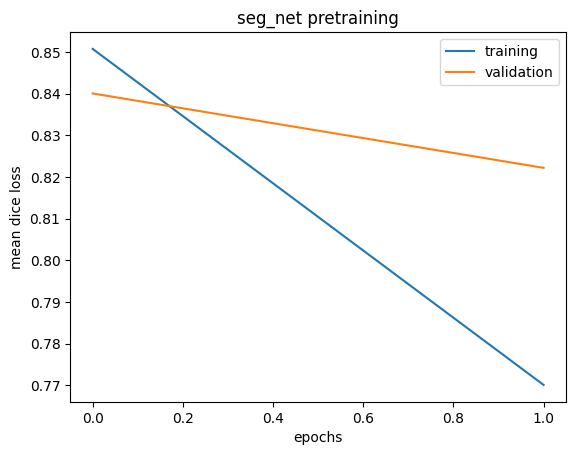

In [21]:
#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION LOSS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- PLOTTING TRAINING AND VALIDATION LOSS")
print("#-------------------------------------------------------------\n")

# Plot the training and validation losses
plot_against_epoch_numbers(training_losses, label="training")
plot_against_epoch_numbers(validation_losses, label="validation")
plt.legend()
plt.ylabel("mean dice loss")
plt.title("seg_net pretraining")
plt.savefig("seg_net_pretrained_losses.png")
plt.show()

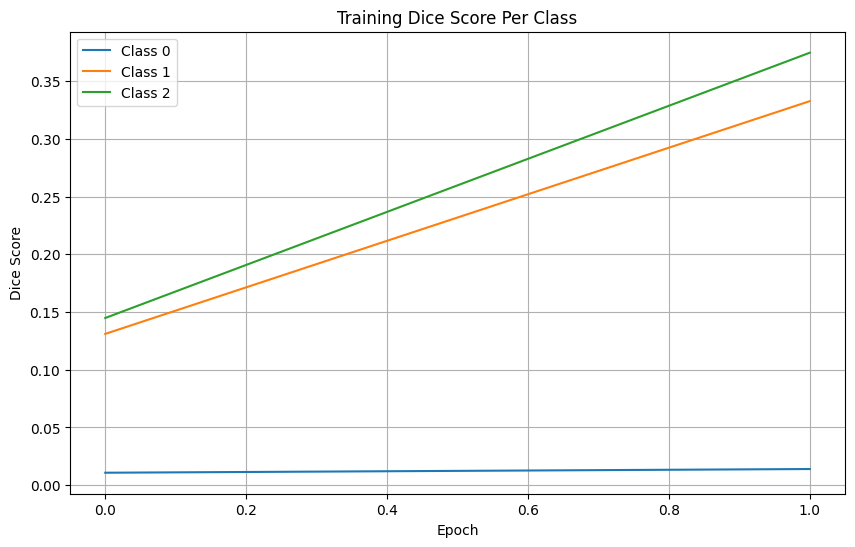

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to NumPy arrays
training_dice_per_class_np = np.array(training_dice_per_class, dtype=np.float32)

num_classes = training_dice_per_class_np.shape[1] - 1  # first column is epoch

# Plot validation dice per class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(training_dice_per_class_np[:, 0], training_dice_per_class_np[:, i + 1], label=f"Class {i}")

plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Training Dice Score Per Class")
plt.legend()
plt.grid(True)
plt.savefig("validation_dice_per_class.png")
plt.show()


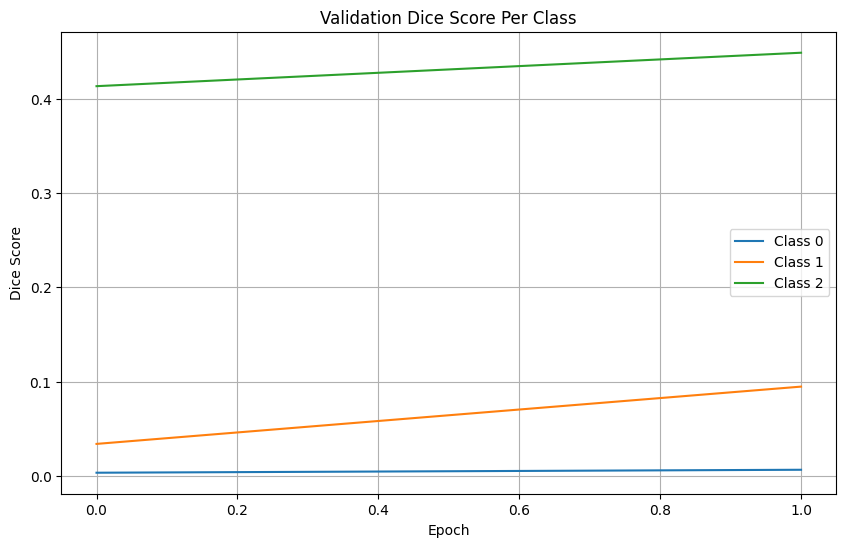

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Convert to NumPy arrays
validation_dice_per_class_np = np.array(validation_dice_per_class, dtype=np.float32)

num_classes = validation_dice_per_class_np.shape[1] - 1  # first column is epoch

# Plot validation dice per class
plt.figure(figsize=(10, 6))
for i in range(num_classes):
    plt.plot(validation_dice_per_class_np[:, 0], validation_dice_per_class_np[:, i + 1], label=f"Class {i}")

plt.xlabel("Epoch")
plt.ylabel("Dice Score")
plt.title("Validation Dice Score Per Class")
plt.legend()
plt.grid(True)
plt.savefig("validation_dice_per_class.png")
plt.show()


#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION DICE
#-------------------------------------------------------------



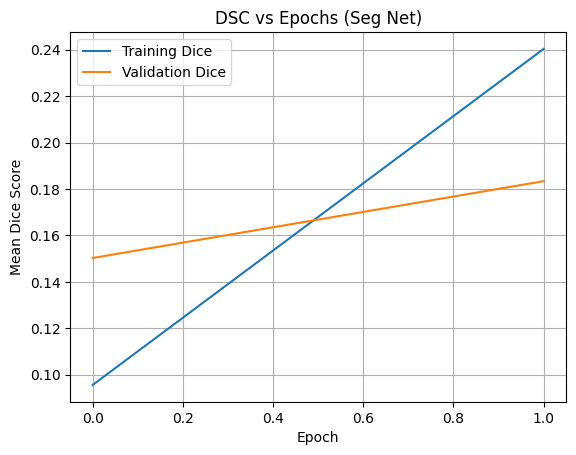

In [24]:
#-------------------------------------------------------------
#--- PLOTTING TRAINING AND VALIDATION DICE
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- PLOTTING TRAINING AND VALIDATION DICE")
print("#-------------------------------------------------------------\n")

# Convert to numpy arrays for easy indexing
training_dices_np = np.array(training_dices)
validation_dices_np = np.array(validation_dices)

plt.plot(training_dices_np[:, 0], training_dices_np[:, 1], label="Training Dice")
plt.plot(validation_dices_np[:, 0], validation_dices_np[:, 1], label="Validation Dice")
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Score")
plt.title("DSC vs Epochs (Seg Net)")
plt.legend()
plt.grid(True)
plt.savefig("dice_score_vs_epoch.png")
plt.show()


In [25]:
#-------------------------------------------------------------
#--- CHECKPOINT LOAD IF NECESSARY
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHECKPOINT LOAD IF NECESSARY")
print("#-------------------------------------------------------------\n")

# CHECKPOINT CELL; LOAD
# seg_net.load_state_dict(torch.load('seg_net_pretrained.pth', weights_only=True))

#-------------------------------------------------------------
#--- CHECKPOINT LOAD IF NECESSARY
#-------------------------------------------------------------



#-------------------------------------------------------------
#--- TRYING OUT SEGNET ON RANDOM VALIDATION
#-------------------------------------------------------------

Original image from validation set:


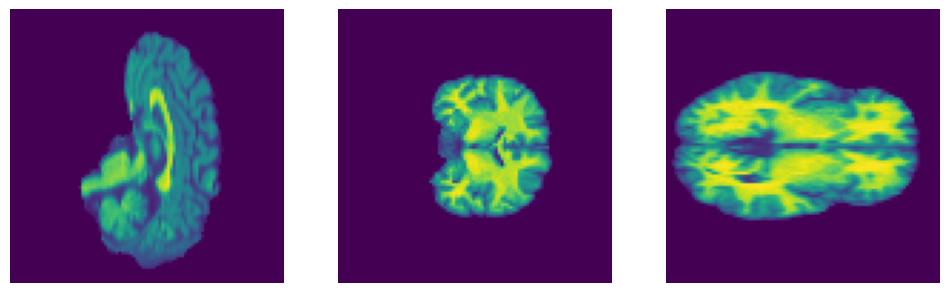

Ground truth segmentation:


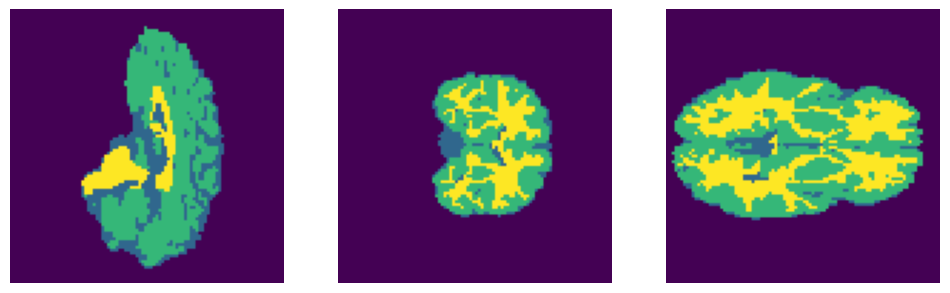

Our predicted segmentation:


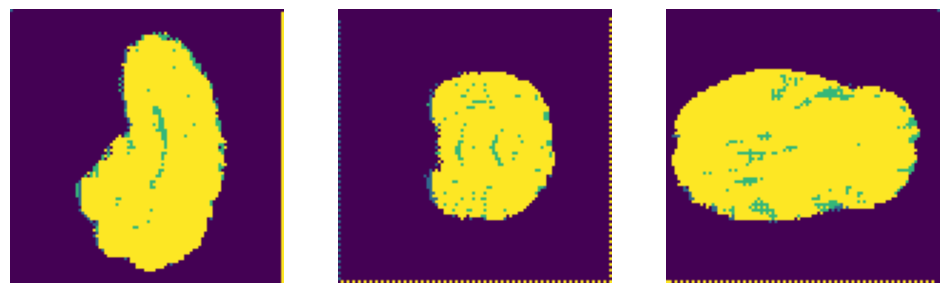

In [26]:
#-------------------------------------------------------------
#--- TRYING OUT SEGNET ON RANDOM VALIDATION
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- TRYING OUT SEGNET ON RANDOM VALIDATION")
print("#-------------------------------------------------------------\n")

seg_net.to(device)

data_item = random.choice(dataset_seg_available_valid)
test_input = data_item["img"]
test_seg_true = data_item["seg"]
seg_net.eval()
with torch.no_grad():
    test_seg_predicted = seg_net(test_input.unsqueeze(0).cuda()).cpu()

print("Original image from validation set:")
preview_image(test_input[0])
print("Ground truth segmentation:")
preview_image(test_seg_true[0])
print("Our predicted segmentation:")
preview_image(torch.argmax(torch.softmax(test_seg_predicted, dim=1), dim=1, keepdim=True)[0, 0])

del test_seg_predicted
torch.cuda.empty_cache()

In [27]:
#-------------------------------------------------------------
#--- SPLITTING DATA FOR COMBINED MODELS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- SPLITTING DATA FOR COMBINED MODELS")
print("#-------------------------------------------------------------\n")

data_without_seg_valid = data_seg_unavailable + data_seg_available_train  # Note the order
print(data_without_seg_valid)

# For 18
val_ids = ["IBSR_03.nii", "IBSR_06.nii", "IBSR_07.nii", "IBSR_12.nii", "IBSR_13.nii"]
# # For 20
# val_ids = ["IBSR_07.nii", "IBSR_09.nii", "IBSR_12.nii", "IBSR_13.nii", "IBSR_17.nii"]

#-------------------------------------------------------------
#--- SPLITTING DATA FOR COMBINED MODELS
#-------------------------------------------------------------

# Initialize empty lists
data_valid = []
data_train = []

# Loop through data_without_seg_valid and split
for item in data_without_seg_valid:
    img_path = item["img"]
    img_name = os.path.basename(img_path)
    if img_name in val_ids:
        data_valid.append(item)
    else:
        data_train.append(item)

# Print results to verify
print(f"Number of training samples: {len(data_train)}")
print(f"Number of validation samples: {len(data_valid)}")
print("\nValidation items:")
for val in data_valid:
    print(val)

#-------------------------------------------------------------
#--- SPLITTING DATA FOR COMBINED MODELS
#-------------------------------------------------------------

[{'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_03.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_06.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_07.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_12.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_13.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_01.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_01.nii'}, {'img': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_02.nii', 'seg': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\

In [28]:
#-------------------------------------------------------------
#--- CREATING ALL POSSIBLE PAIRS OF IMAGES AND THEIR AVAILABLE CORRESPONDING SEGMENTATIONS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CREATING ALL POSSIBLE PAIRS OF IMAGES AND THEIR AVAILABLE CORRESPONDING SEGMENTATIONS")
print("#-------------------------------------------------------------\n")

def take_data_pairs(data, symmetric=True):
    """Given a list of dicts that have keys for an image and maybe a segmentation,
    return a list of dicts corresponding to *pairs* of images and maybe segmentations.
    Pairs consisting of a repeated image are not included.
    If symmetric is set to True, then for each pair that is included, its reverse is also included"""
    data_pairs = []
    for i in range(len(data)):
        j_limit = len(data) if symmetric else i
        for j in range(j_limit):
            if j == i:
                continue
            d1 = data[i]
            d2 = data[j]
            pair = {"img1": d1["img"], "img2": d2["img"]}
            if "seg" in d1.keys():
                pair["seg1"] = d1["seg"]
            if "seg" in d2.keys():
                pair["seg2"] = d2["seg"]
            data_pairs.append(pair)
    return data_pairs

data_pairs_valid = take_data_pairs(data_valid)
data_pairs_train = take_data_pairs(data_train)

#-------------------------------------------------------------
#--- CREATING ALL POSSIBLE PAIRS OF IMAGES AND THEIR AVAILABLE CORRESPONDING SEGMENTATIONS
#-------------------------------------------------------------



In [29]:
#-------------------------------------------------------------
#--- PRINTING ABOVE DATA PAIRS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- PRINTING ABOVE DATA PAIRS")
print("#-------------------------------------------------------------\n")

def print_data_pairs(data_pairs, max_print=5):
    print(f"Total pairs: {len(data_pairs)}\n")
    for i, pair in enumerate(data_pairs):
        if i >= max_print:
            print(f"... and {len(data_pairs) - max_print} more pairs.")
            break
        print(f"Pair {i + 1}:")
        print(f"  img1: {pair.get('img1')}")
        print(f"  img2: {pair.get('img2')}")
        if 'seg1' in pair:
            print(f"  seg1: {pair['seg1']}")
        if 'seg2' in pair:
            print(f"  seg2: {pair['seg2']}")
        print()

print("Validation Data Pairs:")
print_data_pairs(data_pairs_valid)

print("\nTraining Data Pairs:")
print_data_pairs(data_pairs_train)


#-------------------------------------------------------------
#--- PRINTING ABOVE DATA PAIRS
#-------------------------------------------------------------

Validation Data Pairs:
Total pairs: 20

Pair 1:
  img1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_03.nii
  img2: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_06.nii

Pair 2:
  img1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_03.nii
  img2: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_07.nii

Pair 3:
  img1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_03.nii
  img2: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_12.nii

Pair 4:
  img1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_03.nii
  img2: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_13.nii

Pair 5:
  img1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_

In [30]:
#-------------------------------------------------------------
#--- CATEGORIZING A LIST OF IMAGE PAIRS INTO FOUR GROUPS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CATEGORIZING A LIST OF IMAGE PAIRS INTO FOUR GROUPS")
print("#-------------------------------------------------------------\n")

def subdivide_list_of_data_pairs(data_pairs_list):
    out_dict = {"00": [], "01": [], "10": [], "11": []}
    for d in data_pairs_list:
        if "seg1" in d.keys() and "seg2" in d.keys():
            out_dict["11"].append(d)
        elif "seg1" in d.keys():
            out_dict["10"].append(d)
        elif "seg2" in d.keys():
            out_dict["01"].append(d)
        else:
            out_dict["00"].append(d)
    return out_dict

data_pairs_valid_subdivided = subdivide_list_of_data_pairs(data_pairs_valid)
data_pairs_train_subdivided = subdivide_list_of_data_pairs(data_pairs_train)

# Print each group on a new line
print("Training Pairs Subdivided:")
for key, value in data_pairs_train_subdivided.items():
    print(f"{key}: {len(value)} pairs")

print(data_pairs_train_subdivided, "\n")
print(data_pairs_valid_subdivided, "\n")

#-------------------------------------------------------------
#--- CATEGORIZING A LIST OF IMAGE PAIRS INTO FOUR GROUPS
#-------------------------------------------------------------

Training Pairs Subdivided:
00: 0 pairs
01: 0 pairs
10: 0 pairs
11: 90 pairs
{'00': [], '01': [], '10': [], '11': [{'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_01.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_02.nii', 'seg1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_01.nii', 'seg2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_02.nii'}, {'img1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_01.nii', 'img2': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Img\\IBSR_04.nii', 'seg1': 'C:\\Users\\Praful\\OneDrive\\Desktop\\ChoorneSoch\\OASIS_root\\IBSR_Mask\\IBSR_01.nii', 'seg2': 'C:\\Users\\Praf

In [31]:
#-------------------------------------------------------------
#--- CHECKING ABOVE GROUPS
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CHECKING ABOVE GROUPS")
print("#-------------------------------------------------------------\n")

def print_subdivided_data_pairs(data_dict, title="Data Pairs Subdivided"):
    print(title)
    for key in sorted(data_dict.keys()):
        print(f"\nCategory '{key}' - Total: {len(data_dict[key])}")
        for i, pair in enumerate(data_dict[key], 1):
            print(f"  Pair {i}:")
            for k, v in pair.items():
                print(f"    {k}: {v}")
        if len(data_dict[key]) == 0:
            print("    (No pairs)")

print_subdivided_data_pairs(data_pairs_train_subdivided, "Training Data Pairs Subdivided")
print("\n" + "="*40 + "\n")
print_subdivided_data_pairs(data_pairs_valid_subdivided, "Validation Data Pairs Subdivided")


#-------------------------------------------------------------
#--- CHECKING ABOVE GROUPS
#-------------------------------------------------------------

Training Data Pairs Subdivided

Category '00' - Total: 0
    (No pairs)

Category '01' - Total: 0
    (No pairs)

Category '10' - Total: 0
    (No pairs)

Category '11' - Total: 90
  Pair 1:
    img1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_01.nii
    img2: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_02.nii
    seg1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Mask\IBSR_01.nii
    seg2: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Mask\IBSR_02.nii
  Pair 2:
    img1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_01.nii
    img2: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_04.nii
    seg1: C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Mask\IBSR_01.nii
    seg2: C:\Users\Praful\OneDriv

In [32]:
#-------------------------------------------------------------
#--- CATEGORY INFO
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- CATEGORY INFO")
print("#-------------------------------------------------------------\n")

# print some useful counts to be aware of
num_train_reg_net = len(data_pairs_train)
num_valid_reg_net = len(data_pairs_valid)
num_train_both = (
    len(data_pairs_train_subdivided["01"])
    + len(data_pairs_train_subdivided["10"])
    + len(data_pairs_train_subdivided["11"])
)

print(f"""We have {num_train_both} pairs to train reg_net and seg_net together,
  and an additional {num_train_reg_net - num_train_both} to train reg_net alone.""")
print(f"We have {num_valid_reg_net} pairs for reg_net validation.")

#-------------------------------------------------------------
#--- CATEGORY INFO
#-------------------------------------------------------------

We have 90 pairs to train reg_net and seg_net together,
  and an additional 0 to train reg_net alone.
We have 20 pairs for reg_net validation.


In [33]:
#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- APPLYING PREPROCESSING TRANSFORMATION")
print("#-------------------------------------------------------------\n")

def unsqueeze_if_needed(x):
    # Squeeze last dim if it's singleton channel dim
    if x.ndim == 3:
        return x.unsqueeze(3)
    return x

transform_pair = monai.transforms.Compose(
    transforms=[
        monai.transforms.LoadImageD(keys=["img1", "seg1", "img2", "seg2"], image_only=True, allow_missing_keys=True),
        monai.transforms.LambdaD(keys=["img1", "seg1", "img2", "seg2"], func=unsqueeze_if_needed, allow_missing_keys=True),
        monai.transforms.TransposeD(keys=["img1", "seg1", "img2", "seg2"], indices=(3,2, 1, 0), allow_missing_keys=True),
        monai.transforms.ConcatItemsD(keys=["img1", "img2"], name="img12", dim=0),
        monai.transforms.DeleteItemsD(keys=["img1", "img2"]),
        (
            monai.transforms.ResizeD(
                keys=["img12", "seg1", "seg2"],
                spatial_size= resize,
                mode=["trilinear", "nearest", "nearest"],
                allow_missing_keys=True,
                align_corners=[False, None, None],
            )
            if resize is not None
            else monai.transforms.Identity()
        ),
    ]
)

dataset_pairs_train_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_train_subdivided.items()
}

dataset_pairs_valid_subdivided = {
    seg_availability: monai.data.CacheDataset(data=data_list, transform=transform_pair, cache_num=4) # 32
    for seg_availability, data_list in data_pairs_valid_subdivided.items()
}


#-------------------------------------------------------------
#--- APPLYING PREPROCESSING TRANSFORMATION
#-------------------------------------------------------------



Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  3.79it/s]


In [34]:
#-------------------------------------------------------------
#--- DEFINING REG NET
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- DEFINING REG NET")
print("#-------------------------------------------------------------\n")

# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.UNet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 32, 32),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)
'''
# Similar architecture to the one used in the paper
reg_net = monai.networks.nets.VoxelMorphUNet(
    3,  # spatial dims
    2,  # input channels (one for fixed image and one for moving image)
    3,  # output channels (to represent 3D displacement vector field)
    (16, 32, 32, 64, 64, 32, 32, 16),  # channel sequence
    (1, 2, 2, 2),  # convolutional strides
    dropout=0.2,
    norm="batch",
)
'''

# Try out a forward pass
def take_random_from_subdivided_dataset(dataset_subdivided):
    """Given a dict mapping segmentation availability labels to datasets, return a random data item"""
    datasets = list(dataset_subdivided.values())
    datasets_combined = sum(datasets[1:], datasets[0])
    return random.choice(datasets_combined)

data_item = take_random_from_subdivided_dataset(dataset_pairs_train_subdivided)
reg_net_example_input = data_item["img12"].unsqueeze(0)
reg_net_example_output = reg_net(reg_net_example_input)
print(f"Shape of reg_net input: {reg_net_example_input.shape}")
'''
1: Batch size (single image pair)
2: Channels — this represents a pair of 3D images:
    Channel 0: Fixed image
    Channel 1: Moving image
96, 96, 96: The 3D spatial dimensions of each image (width × height × depth)
'''
print(f"Shape of reg_net output: {reg_net_example_output.shape}")
'''
1: Batch size
3: Channels → this represents the 3D displacement vector field:
Channel 0: displacement in x-direction
Channel 1: displacement in y-direction
Channel 2: displacement in z-direction
96, 96, 96: Same spatial size as the input — meaning there's a 3D vector at every voxel, telling how to move it
'''
image_scale = reg_net_example_input.shape[-1]  # comes in handy later



#-------------------------------------------------------------
#--- DEFINING REG NET
#-------------------------------------------------------------

Shape of reg_net input: torch.Size([1, 2, 96, 96, 96])
Shape of reg_net output: torch.Size([1, 3, 96, 96, 96])



#-------------------------------------------------------------
#--- PERFORMING IMAGE WARPING
#-------------------------------------------------------------



monai.networks.blocks.Warp: Using PyTorch native grid_sample.


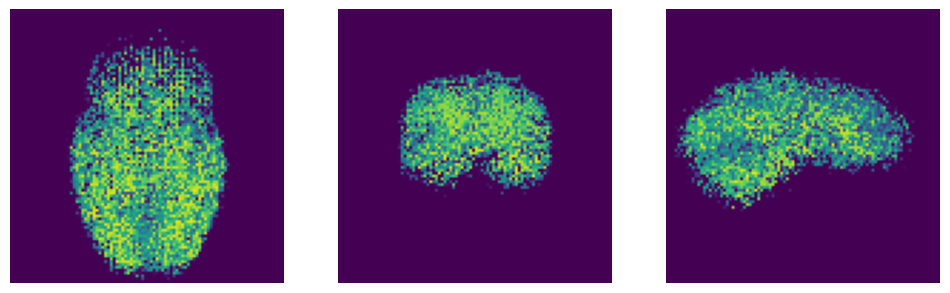

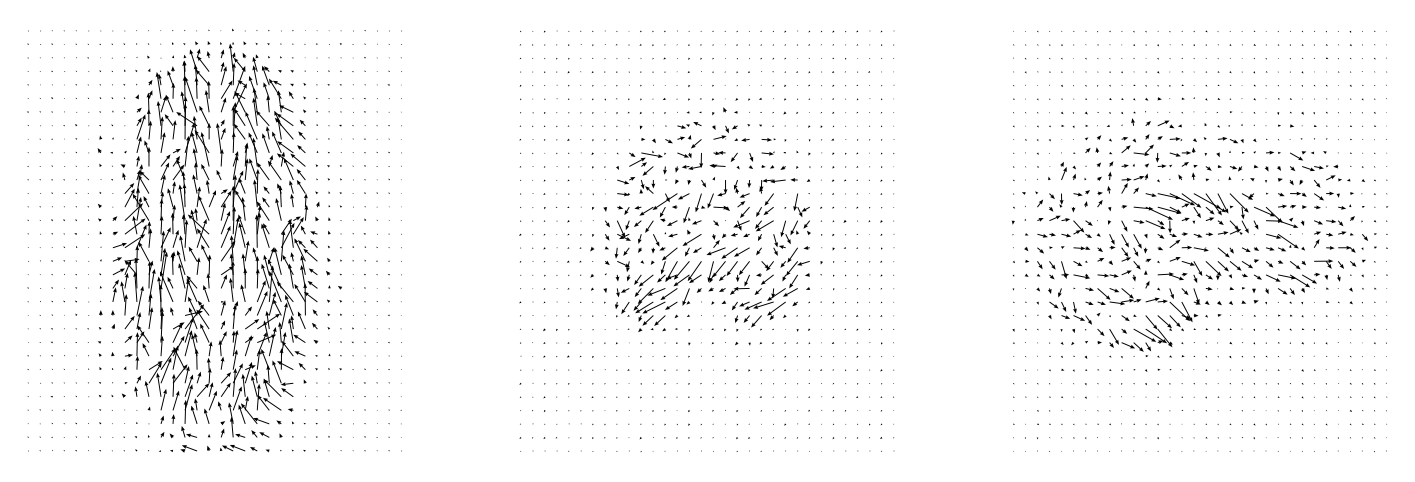

In [35]:
#-------------------------------------------------------------
#--- PERFORMING IMAGE WARPING
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- PERFORMING IMAGE WARPING")
print("#-------------------------------------------------------------\n")

# For warping segmentation labels or class predictions, we sometimes want to use nearest neighbor interpolation
# Note that "bilinear" means "trilinear" in the case of 3D images
warp = monai.networks.blocks.Warp( ############## YO WARP PACHI NI USE HUNXA
    mode="bilinear", 
    padding_mode="border",
)
warp_nearest = monai.networks.blocks.Warp(mode="nearest", padding_mode="border")

# Use example reg_net output to apply warp
example_warped_image = warp(
    data_item["img12"][[1], :, :, :].unsqueeze(0), reg_net_example_output  # moving image  # warping
)

# Previewing warped image
preview_image(example_warped_image[0,0].detach())

# Previewing displacement field
preview_3D_vector_field(reg_net_example_output.detach()[0])

In [36]:
#-------------------------------------------------------------
#--- INITIALIZING A SWAP FUNCTION
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- INITIALIZING A SWAP FUNCTION")
print("#-------------------------------------------------------------\n")

# While training for one network we dont want to computer gradients for the other network
def swap_training(network_to_train, network_to_not_train):
    """
    Switch out of training one network and into training another
    """
    for param in network_to_not_train.parameters():
        param.requires_grad = False

    for param in network_to_train.parameters():
        param.requires_grad = True

    network_to_not_train.eval()
    network_to_train.train()


#-------------------------------------------------------------
#--- INITIALIZING A SWAP FUNCTION
#-------------------------------------------------------------



In [37]:
#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- INITIALIZING DATALOADER")
print("#-------------------------------------------------------------\n")

# The following are dictionaries that map segmentation availability labels 00,10,01,11 to MONAI dataloaders

dataloader_pairs_train_subdivided = {
    seg_availability: (
        monai.data.DataLoader(
            dataset, 
            batch_size=2, 
            num_workers=0, 
            shuffle=True,
        ) 
        if len(dataset) > 0 
        else [] # Number of workers can be set to 4 for better performance
    )  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_train_subdivided.items()
}

dataloader_pairs_valid_subdivided = {
    seg_availability: (
        monai.data.DataLoader(
            dataset,
            batch_size=4,
            num_workers=0, # 4
            shuffle=True,  # Shuffle validation data because we will only take a sample for validation each time
        )
        if len(dataset) > 0
        else []
    )  # empty dataloaders are not a thing-- put an empty list if needed
    for seg_availability, dataset in dataset_pairs_valid_subdivided.items()
}

#-------------------------------------------------------------
#--- INITIALIZING DATALOADER
#-------------------------------------------------------------



In [38]:
#-------------------------------------------------------------
#--- REGISTRATION LOSS FUNCTIONS
#-------------------------------------------------------------

print("\n#-------------------------------------------------------------")
print("#--- REGISTRATION LOSS FUNCTIONS")
print("#-------------------------------------------------------------\n")

lncc_loss = monai.losses.LocalNormalizedCrossCorrelationLoss(
    spatial_dims=3, kernel_size=3, kernel_type="rectangular", reduction="mean"
)

# Uncomment to try out the image similarity loss on the example.
lncc_loss(
    example_warped_image, # registered image
    data_item['img12'][[0],:,:,:].unsqueeze(0) # target ("fixed image")
)

bending_loss = monai.losses.BendingEnergyLoss()
# Uncomment to try out the bending energy loss on the example
bending_loss(reg_net_example_output)

regularization_loss = bending_loss

def similarity_loss(displacement_field, image_pair):
    """Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D)."""
    warped_img2 = warp(image_pair[:, [1], :, :, :], displacement_field)
    return lncc_loss(warped_img2, image_pair[:, [0], :, :, :])  # prediction  # target

def anatomy_loss(displacement_field, image_pair, seg_net, gt_seg1=None, gt_seg2=None):
    """
    Accepts a batch of displacement fields, shape (B,3,H,W,D),
    and a batch of image pairs, shape (B,2,H,W,D).
    seg_net is the model used to segment an image,
      mapping (B,1,H,W,D) to (B,C,H,W,D) where C is the number of segmentation classes.
    gt_seg1 and gt_seg2 are ground truth segmentations for the images in image_pair, if ground truth is available;
      if unavailable then they can be None.
      gt_seg1 and gt_seg2 are expected to be in the form of class labels, with shape (B,1,H,W,D).
    """
    if gt_seg1 is not None:
        # ground truth seg of target image
        seg1 = monai.networks.one_hot(gt_seg1, num_segmentation_classes)
    else:
        # seg_net on target image, "noisy ground truth"
        seg1 = seg_net(image_pair[:, [0], :, :, :]).softmax(dim=1)

    if gt_seg2 is not None:
        # ground truth seg of moving image
        seg2 = monai.networks.one_hot(gt_seg2, num_segmentation_classes)
    else:
        # seg_net on moving image, "noisy ground truth"
        seg2 = seg_net(image_pair[:, [1], :, :, :]).softmax(dim=1)

    # seg1 and seg2 are now in the form of class probabilities at each voxel
    # The trilinear interpolation of the function `warp` is then safe to use;
    # it will preserve the probabilistic interpretation of seg2.

    return dice_loss2(
        warp(seg2, displacement_field), seg1  # warp of moving image segmentation  # target image segmentation
    )

def reg_losses(batch):
    img12 = batch["img12"].to(device)

    displacement_field12 = reg_net(img12)

    loss_sim = similarity_loss(displacement_field12, img12)

    loss_reg = regularization_loss(displacement_field12)

    gt_seg1 = batch["seg1"].to(device) if "seg1" in batch.keys() else None
    gt_seg2 = batch["seg2"].to(device) if "seg2" in batch.keys() else None
    loss_ana = anatomy_loss(displacement_field12, img12, seg_net, gt_seg1, gt_seg2)

    return loss_sim, loss_reg, loss_ana


#-------------------------------------------------------------
#--- REGISTRATION LOSS FUNCTIONS
#-------------------------------------------------------------



In [39]:
#-------------------------------------------------------------
#--- DEFINING BATCH GENERATOR
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- DEFINING BATCH GENERATOR")
print("#-------------------------------------------------------------\n")

seg_availabilities = ["00", "01", "10", "11"]


def create_batch_generator(dataloader_subdivided, weights=None):
    """
    Create a batch generator that samples data pairs with various segmentation availabilities.

    Arguments:
        dataloader_subdivided : a mapping from the labels in seg_availabilities to dataloaders
        weights : a list of probabilities, one for each label in seg_availabilities;
                  if not provided then we weight by the number of data items of each type,
                  effectively sampling uniformly over the union of the datasets

    Returns: batch_generator
        A function that accepts a number of batches to sample and that returns a generator.
        The generator will weighted-randomly pick one of the seg_availabilities and
        yield the next batch from the corresponding dataloader.
    """
    if weights is None:
        weights = np.array([len(dataloader_subdivided[s]) for s in seg_availabilities])
    weights = np.array(weights)
    weights = weights / weights.sum()
    dataloader_subdivided_as_iterators = {s: iter(d) for s, d in dataloader_subdivided.items()}

    def batch_generator(num_batches_to_sample):
        for _ in range(num_batches_to_sample):
            seg_availability = np.random.choice(seg_availabilities, p=weights)
            try:
                yield next(dataloader_subdivided_as_iterators[seg_availability])
            except StopIteration:  # If dataloader runs out, restart it
                dataloader_subdivided_as_iterators[seg_availability] = iter(dataloader_subdivided[seg_availability])
                yield next(dataloader_subdivided_as_iterators[seg_availability])

    return batch_generator

batch_generator_train_reg = create_batch_generator(dataloader_pairs_train_subdivided)
batch_generator_valid_reg = create_batch_generator(dataloader_pairs_valid_subdivided)

#-------------------------------------------------------------
#--- DEFINING BATCH GENERATOR
#-------------------------------------------------------------



In [40]:
#-------------------------------------------------------------
#--- SEG INFO
#-------------------------------------------------------------

print("#-------------------------------------------------------------")
print("#--- SEG INFO")
print("#-------------------------------------------------------------\n")

# When training seg_net alone, we only consider data pairs for which at least one ground truth seg is available
seg_train_sampling_weights = [0] + [len(dataloader_pairs_train_subdivided[s]) for s in seg_availabilities[1:]]
print(
    f"""When training seg_net alone, segmentation availabilities {seg_availabilities}
will be sampled with respective weights {seg_train_sampling_weights}"""
)
batch_generator_train_seg = create_batch_generator(dataloader_pairs_train_subdivided, seg_train_sampling_weights)

#-------------------------------------------------------------
#--- SEG INFO
#-------------------------------------------------------------

When training seg_net alone, segmentation availabilities ['00', '01', '10', '11']
will be sampled with respective weights [0, 0, 0, 45]


# Combined Model Code

In [42]:
# Training cell
# (if already done then you may skip this and uncomment the loading checkpoint cell below)

# Set up checkpoint directory
save_dir = os.path.join(".", "DeepAtlas__Checkpoint")
os.makedirs(save_dir, exist_ok=True)

# Reload pretrained seg_net weights explicitly before starting DeepAtlas training
ld_wt = r"C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\Init_Seg_Train_Checkpoint\best_pre_segnet18.pt"
seg_net.load_state_dict(torch.load(ld_wt))

seg_net.to(device)
reg_net.to(device)

# Early stopping
patience = 49
early_stopping_counter = 0

learning_rate_reg = 5e-4
optimizer_reg = torch.optim.Adam(reg_net.parameters(), learning_rate_reg)

learning_rate_seg = 1e-3
optimizer_seg = torch.optim.Adam(seg_net.parameters(), learning_rate_seg)

lambda_a = 2.0  # anatomy loss weight
lambda_sp = 3.0  # supervised segmentation loss weight

# regularization loss weight
# This often requires some careful tuning. Here we suggest a value, which unfortunately needs to
# depend on image scale. This is because the bending energy loss is not scale-invariant.
# 7.5 worked well with the above hyperparameters for images of size 128x128x128.
lambda_r = 7.5 * (image_scale / 128) ** 2

max_epochs = 2 # 120
reg_phase_training_batches_per_epoch = 5 #40 
seg_phase_training_batches_per_epoch = 1 #5  # Fewer batches needed, because seg_net converges more quickly
reg_phase_num_validation_batches_to_use = 5 #40
val_interval = 1 # 5

training_losses_reg,validation_losses_reg = [],[]
training_losses_seg,validation_losses_seg = [], []
best_seg_validation_loss, best_reg_validation_loss = float("inf") ,float("inf")

training_dices, validation_dices = [], []
training_dice_per_class, validation_dice_per_class = [], []

# Track best scores
best_training_dice = 0.0
best_training_epoch = -1
best_training_dice_classes = []

best_validation_dice = 0.0
best_validation_epoch = -1
best_validation_dice_classes = []

epoch_training_times = []

foreground_classes = [1, 2, 3]  # Assuming class 0 is background

for epoch_number in range(max_epochs):
    print(f"Epoch {epoch_number+1}/{max_epochs}:")

    # ------------------------------------------------
    #         reg_net training, with seg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for reg_net, but not for seg_net, and do reg_net.train()
    swap_training(reg_net, seg_net)

    losses = []
    for batch in batch_generator_train_reg(reg_phase_training_batches_per_epoch):
        optimizer_reg.zero_grad()
        loss_sim, loss_reg, loss_ana = reg_losses(batch)
        loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
        loss.backward()
        optimizer_reg.step()
        losses.append(loss.item())

    training_loss = np.mean(losses)
    print(f"\treg training loss: {training_loss}")
    training_losses_reg.append([epoch_number, training_loss])

    if epoch_number % val_interval == 0:
        reg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in batch_generator_valid_reg(reg_phase_num_validation_batches_to_use):
                loss_sim, loss_reg, loss_ana = reg_losses(batch)
                loss = loss_sim + lambda_r * loss_reg + lambda_a * loss_ana
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\treg validation loss: {validation_loss}")
        validation_losses_reg.append([epoch_number, validation_loss])

        if validation_loss < best_reg_validation_loss:
            best_reg_validation_loss = validation_loss
            checkpoint_path_reg = os.path.join(save_dir, "reg_net_best.pth")
            torch.save(reg_net.state_dict(), checkpoint_path_reg)
            print(f"\t💾 Saved best reg_net model at: {checkpoint_path_reg}")

    # Free up memory
    del loss, loss_sim, loss_reg, loss_ana
    torch.cuda.empty_cache()

    # ------------------------------------------------
    #         seg_net training, with reg_net frozen
    # ------------------------------------------------

    # Keep computational graph in memory for seg_net, but not for reg_net, and do seg_net.train()
    swap_training(seg_net, reg_net)
    epoch_start = time.time()

    losses = []
    for batch in batch_generator_train_seg(seg_phase_training_batches_per_epoch):
        optimizer_seg.zero_grad()

        img12 = batch["img12"].to(device)
        displacement_fields = reg_net(img12)
        seg1_predicted = seg_net(img12[:, [0], :, :, :]).softmax(dim=1)
        seg2_predicted = seg_net(img12[:, [1], :, :, :]).softmax(dim=1)

        # Below we compute the following:
        # loss_supervised: supervised segmentation loss; compares ground truth seg with predicted seg
        # loss_anatomy: anatomy loss; compares warped seg of moving image to seg of target image
        # loss_metric: a single supervised seg loss, as a metric to track the progress of training

        if "seg1" in batch.keys() and "seg2" in batch.keys():
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = dice_loss2(seg1_predicted, seg1) + loss_metric
            print(f"seg2 : {seg2.shape} seg2_predicted: {seg2_predicted.shape}")
            print(f"seg1 : {seg1.shape} seg1_predicted: {seg1_predicted.shape}")

            # The above supervised loss looks a bit different from the one in the paper
            # in that it includes predictions for both images in the current image pair;
            # we might as well do this, since we have gone to the trouble of loading
            # both segmentations into memory.

        elif "seg1" in batch.keys():  # seg1 available, but no seg2
            seg1 = monai.networks.one_hot(batch["seg1"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg1_predicted, seg1)
            loss_supervised = loss_metric
            seg2 = seg2_predicted  # Use this in anatomy loss
            print(f"seg1 : {seg1.shape} seg1_predicted: {seg1_predicted.shape}")

        else:  # seg2 available, but no seg1
            assert "seg2" in batch.keys()
            seg2 = monai.networks.one_hot(batch["seg2"].to(device), num_segmentation_classes)
            loss_metric = dice_loss2(seg2_predicted, seg2)
            loss_supervised = loss_metric
            seg1 = seg1_predicted  # Use this in anatomy loss
            print(f"seg2 : {seg2.shape} seg2_predicted: {seg2_predicted.shape}")

        # seg1 and seg2 should now be in the form of one-hot class probabilities
        loss_anatomy = (
            dice_loss2(warp_nearest(seg2, displacement_fields), seg1)
            if "seg1" in batch.keys() or "seg2" in batch.keys()
            else 0.0
        )  # It wouldn't really be 0, but it would not contribute to training seg_net

        # (If you want to refactor this code for *joint* training of reg_net and seg_net,
        #  then use the definition of anatomy loss given in the function anatomy_loss above,
        #  where differentiable warping is used and reg net can be trained with it.)

        loss = lambda_a * loss_anatomy + lambda_sp * loss_supervised
        loss.backward()
        optimizer_seg.step()
        # ADDED BY MEEEE
        with torch.no_grad():
            if "seg1" in batch.keys():
                pred1_onehot = one_hot(seg1_predicted.argmax(1, keepdim=True), num_segmentation_classes)
                dice_metric3(pred1_onehot, seg1)
            if "seg2" in batch.keys():
                pred2_onehot = one_hot(seg2_predicted.argmax(1, keepdim=True), num_segmentation_classes)
                dice_metric3(pred2_onehot, seg2)
        losses.append(loss_metric.item())
    epoch_time = time.time() - epoch_start
    epoch_training_times.append(epoch_time)
    print(f"\tTraining time (no val): {epoch_time:.2f} seconds")
    
    training_loss = np.mean(losses)
    print(f"\tseg training loss: {training_loss}")
    training_losses_seg.append([epoch_number, training_loss])

    # Dice
    dice_scores, _ = dice_metric3.aggregate()
    dice_scores_np = dice_scores.cpu().numpy()
    mean_class_dice = dice_scores_np.mean(axis=0) if dice_scores_np.ndim > 1 else dice_scores_np
    training_dice_per_class.append([epoch_number] + mean_class_dice.tolist())

    training_dice = mean_class_dice.mean().item()
    training_dices.append([epoch_number, training_dice])
    print(f"\ttraining mean foreground DSC: {training_dice:.4f}")

    if training_dice > best_training_dice:
        best_training_dice = training_dice
        best_training_epoch = epoch_number
        best_training_dice_classes = mean_class_dice.tolist()
        print(f"\t🔥 New best training DSC: {best_training_dice:.4f} at epoch {best_training_epoch}")

    dice_metric3.reset()

    for idx, dsc in enumerate(mean_class_dice):
        print(f"\t\tClass {foreground_classes[idx]} training DSC: {dsc:.4f}")

    if epoch_number % val_interval == 0:
        # The following validation loop would not do anything in the case
        # where there is just one segmentation available,
        # because data_seg_available_valid would be empty.
        seg_net.eval()
        losses = []
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)
                predicted_segs = seg_net(imgs)
                loss = dice_loss(predicted_segs, true_segs)
                losses.append(loss.item())

        validation_loss = np.mean(losses)
        print(f"\tseg validation loss: {validation_loss}")
        validation_losses_seg.append([epoch_number, validation_loss])
        # MAA HUU MAAAA YETAAA
        dice_metric3.reset()
        with torch.no_grad():
            for batch in dataloader_seg_available_valid:
                imgs = batch["img"].to(device)
                true_segs = batch["seg"].to(device)

                predicted_segs = seg_net(imgs)
                pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_segmentation_classes)
                true_onehot = one_hot(true_segs, num_segmentation_classes)

                dice_metric3(pred_onehot, true_onehot)

        dice_scores, _ = dice_metric3.aggregate()
        dice_scores_np = dice_scores.cpu().numpy()
        mean_class_dice = dice_scores_np.mean(axis=0) if dice_scores_np.ndim > 1 else dice_scores_np
        validation_dice_per_class.append([epoch_number] + mean_class_dice.tolist())

        validation_dice = mean_class_dice.mean().item()
        validation_dices.append([epoch_number, validation_dice])
        print(f"\tvalidation mean foreground DSC: {validation_dice:.4f}")

        if validation_dice > best_validation_dice:
            best_validation_dice = validation_dice
            best_validation_epoch = epoch_number
            best_validation_dice_classes = mean_class_dice.tolist()
            early_stopping_counter = 0  # reset counter if improved
            print(f"\t🏆 New best validation DSC: {best_validation_dice:.4f} at epoch {best_validation_epoch}")

            # --- Overwrite best model checkpoint ---
            checkpoint_path_seg = os.path.join(save_dir, "best_segnet18.pt")
            torch.save(seg_net.state_dict(), checkpoint_path_seg)
            print(f"\t💾 Overwrote best model at: {checkpoint_path_seg}")
        else:
            early_stopping_counter += 1
            print(f"\t⏳ Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"\t⏰ Early stopping triggered after {patience} epochs without improvement.")
            break

        dice_metric3.reset()

        for idx, dsc in enumerate(mean_class_dice):
            print(f"\t\tClass {foreground_classes[idx]} validation DSC: {dsc:.4f}")

        if validation_loss < best_seg_validation_loss:
            best_seg_validation_loss = validation_loss
            checkpoint_path_seg_loss = os.path.join(save_dir, "seg_net_best.pth")
            torch.save(seg_net.state_dict(), checkpoint_path_seg_loss)
            print(f"\t💾 Saved seg_net best loss model at: {checkpoint_path_seg_loss}")

    # Free up memory
    del (
        loss,
        seg1,
        seg2,
        displacement_fields,
        img12,
        loss_supervised,
        loss_anatomy,
        loss_metric,
        seg1_predicted,
        seg2_predicted,
    )
    torch.cuda.empty_cache()

print(f"\n\nBest reg_net validation loss: {best_reg_validation_loss}")
print(f"Best seg_net validation loss: {best_seg_validation_loss}")

# Summary
print("\n#==============================")
print("#         TRAINING SUMMARY     ")
print("#==============================")
print(f"🔥 Best Training Mean DSC:   {best_training_dice:.4f} at epoch {best_training_epoch}")
print(f"   Per-class DSC: {[f'{d:.4f}' for d in best_training_dice_classes]}")

print(f"🏆 Best Validation Mean DSC: {best_validation_dice:.4f} at epoch {best_validation_epoch}")
print(f"   Per-class DSC: {[f'{d:.4f}' for d in best_validation_dice_classes]}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


Epoch 1/2:
	reg training loss: 10.690573024749757
	reg validation loss: 1.4744306564331056
	💾 Saved best reg_net model at: .\DeepAtlas__Checkpoint\reg_net_best.pth
seg2 : torch.Size([2, 4, 96, 96, 96]) seg2_predicted: torch.Size([2, 4, 96, 96, 96])
seg1 : torch.Size([2, 4, 96, 96, 96]) seg1_predicted: torch.Size([2, 4, 96, 96, 96])
	Training time (no val): 2.27 seconds
	seg training loss: 0.7348906993865967
	training mean foreground DSC: 0.3051
	🔥 New best training DSC: 0.3051 at epoch 0
		Class 1 training DSC: 0.0262
		Class 2 training DSC: 0.4207
		Class 3 training DSC: 0.4684
	seg validation loss: 0.8128984570503235
	validation mean foreground DSC: 0.1974
	🏆 New best validation DSC: 0.1974 at epoch 0
	💾 Overwrote best model at: .\DeepAtlas__Checkpoint\best_segnet18.pt
		Class 1 validation DSC: 0.0025
		Class 2 validation DSC: 0.0992
		Class 3 validation DSC: 0.4905
	💾 Saved seg_net best loss model at: .\DeepAtlas__Checkpoint\seg_net_best.pth
Epoch 2/2:
	reg training loss: 6.01963148

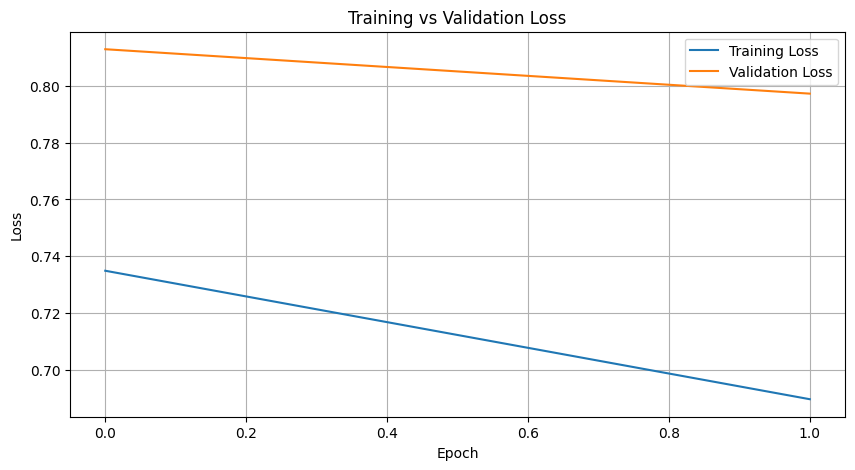

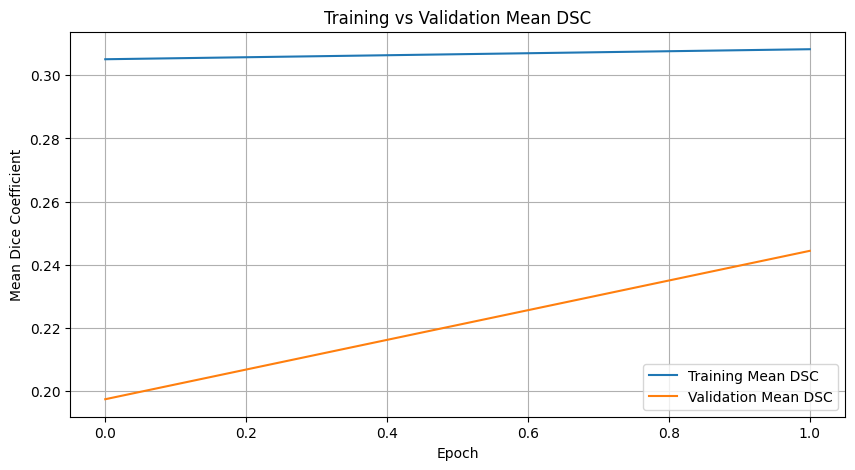

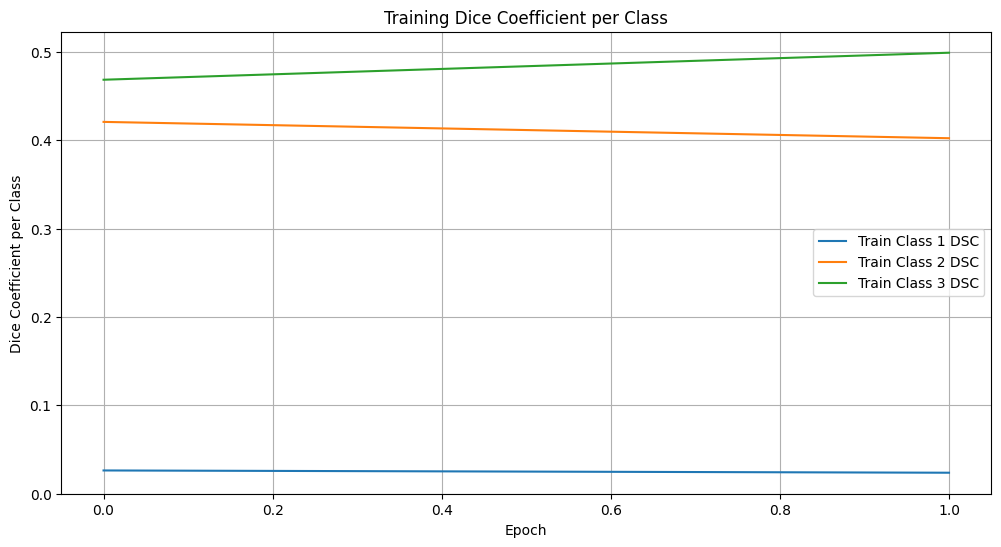

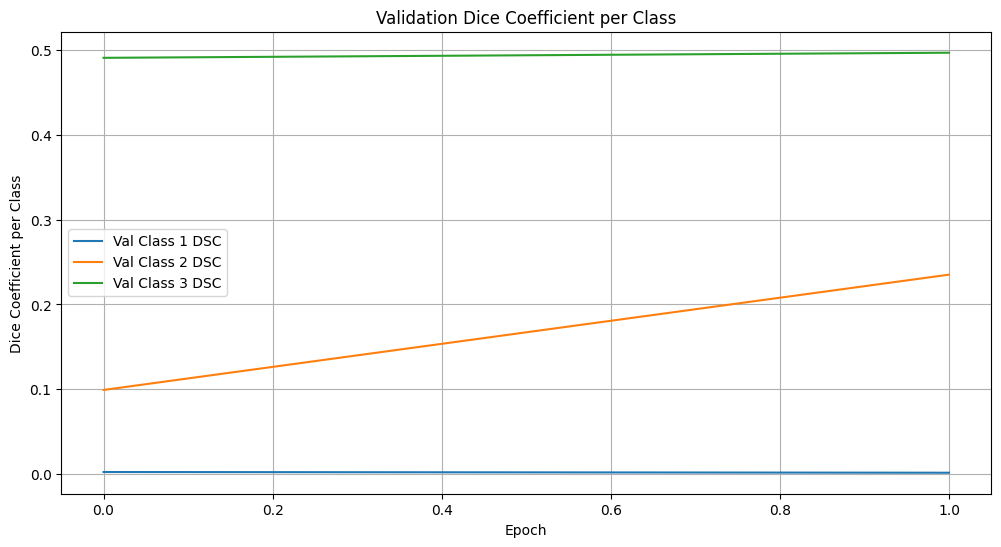

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# Convert to numpy for easy plotting
training_losses_seg_np = np.array(training_losses_seg)
validation_losses_seg_np = np.array(validation_losses_seg)
training_dices_np = np.array(training_dices)
validation_dices_np = np.array(validation_dices)
training_dice_per_class_np = np.array(training_dice_per_class)
validation_dice_per_class_np = np.array(validation_dice_per_class)

epochs_train = training_losses_seg_np[:,0]
epochs_val = validation_losses_seg_np[:,0]

foreground_classes = [1,2,3]  # as defined in your code

# -------------------------------
# 📈 Plot 1: Loss curves
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(epochs_train, training_losses_seg_np[:,1], label="Training Loss")
plt.plot(epochs_val, validation_losses_seg_np[:,1], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 📈 Plot 2: Mean Dice Coefficient
# -------------------------------
plt.figure(figsize=(10,5))
plt.plot(training_dices_np[:,0], training_dices_np[:,1], label="Training Mean DSC")
plt.plot(validation_dices_np[:,0], validation_dices_np[:,1], label="Validation Mean DSC")
plt.xlabel("Epoch")
plt.ylabel("Mean Dice Coefficient")
plt.title("Training vs Validation Mean DSC")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 📈 Plot 3: Training Dice Coefficient per class
# -------------------------------
plt.figure(figsize=(12,6))
for i, class_id in enumerate(foreground_classes):
    plt.plot(training_dice_per_class_np[:,0], training_dice_per_class_np[:,i+1], label=f"Train Class {class_id} DSC")
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient per Class")
plt.title("Training Dice Coefficient per Class")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 📈 Plot 4: Validation Dice Coefficient per class
# -------------------------------
plt.figure(figsize=(12,6))
for i, class_id in enumerate(foreground_classes):
    plt.plot(validation_dice_per_class_np[:,0], validation_dice_per_class_np[:,i+1], label=f"Val Class {class_id} DSC")
plt.xlabel("Epoch")
plt.ylabel("Dice Coefficient per Class")
plt.title("Validation Dice Coefficient per Class")
plt.legend()
plt.grid(True)
plt.show()


In [44]:
# ---------------------------
# Test using seg_net_best.pth
# ---------------------------

# Load checkpoint
checkpoint_path = os.path.join(save_dir, "seg_net_best.pth")
seg_net.load_state_dict(torch.load(checkpoint_path))
seg_net.to(device)
seg_net.eval()

dice_metric3.reset()
with torch.no_grad():
    for batch in dataloader_seg_available_valid:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)

        predicted_segs = seg_net(imgs)
        pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_segmentation_classes)
        true_onehot = one_hot(true_segs, num_segmentation_classes)

        dice_metric3(pred_onehot, true_onehot)

dice_scores, _ = dice_metric3.aggregate()
dice_scores_np = dice_scores.cpu().numpy()
mean_class_dice = dice_scores_np.mean(axis=0) if dice_scores_np.ndim > 1 else dice_scores_np
mean_dice = mean_class_dice.mean().item()

print(f"\n✅ Test results for seg_net_best.pth:")
print(f"Mean foreground DSC: {mean_dice:.4f}")
for idx, dsc in enumerate(mean_class_dice):
    print(f"\tClass {foreground_classes[idx]} DSC: {dsc:.4f}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



✅ Test results for seg_net_best.pth:
Mean foreground DSC: 0.2444
	Class 1 DSC: 0.0016
	Class 2 DSC: 0.2350
	Class 3 DSC: 0.4966


In [45]:
# ---------------------------
# Test using best_segnet18.pt
# ---------------------------

# Load checkpoint
checkpoint_path = os.path.join(save_dir, "best_segnet18.pt")
seg_net.load_state_dict(torch.load(checkpoint_path))
seg_net.to(device)
seg_net.eval()

dice_metric3.reset()
with torch.no_grad():
    for batch in dataloader_seg_available_valid:
        imgs = batch["img"].to(device)
        true_segs = batch["seg"].to(device)

        predicted_segs = seg_net(imgs)
        pred_onehot = one_hot(predicted_segs.argmax(1, keepdim=True), num_segmentation_classes)
        true_onehot = one_hot(true_segs, num_segmentation_classes)

        dice_metric3(pred_onehot, true_onehot)

dice_scores, _ = dice_metric3.aggregate()
dice_scores_np = dice_scores.cpu().numpy()
mean_class_dice = dice_scores_np.mean(axis=0) if dice_scores_np.ndim > 1 else dice_scores_np
mean_dice = mean_class_dice.mean().item()

print(f"\n✅ Test results for best_segnet18.pt:")
print(f"Mean foreground DSC: {mean_dice:.4f}")
for idx, dsc in enumerate(mean_class_dice):
    print(f"\tClass {foreground_classes[idx]} DSC: {dsc:.4f}")


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



✅ Test results for best_segnet18.pt:
Mean foreground DSC: 0.2444
	Class 1 DSC: 0.0016
	Class 2 DSC: 0.2350
	Class 3 DSC: 0.4966


# Img visualization

### Incorrect way

Unique labels in the image: [-7.77156117e-16  8.60847533e-03  1.72169507e-02  2.15211883e-02
  2.58254260e-02  3.01296636e-02  3.44339013e-02  3.87381390e-02
  4.30423766e-02  4.73466143e-02  5.10146171e-02  5.22091165e-02
  5.34036122e-02  5.45981117e-02  5.57926074e-02  5.69871068e-02
  5.81816025e-02  5.93761019e-02  6.05705976e-02  6.17650971e-02
  6.29595965e-02  6.41540959e-02  6.53485879e-02  6.65430874e-02
  6.77375868e-02  6.89320862e-02  7.01265782e-02  7.13210776e-02
  7.25155771e-02  7.37100765e-02  7.49045685e-02  7.60990679e-02
  8.01576823e-02  8.43172595e-02  8.84768218e-02  9.26363990e-02
  9.67959613e-02  1.00958139e-01  1.05315007e-01  1.09671883e-01
  1.14028282e-01  1.18297294e-01  1.22566298e-01  1.26930907e-01
  1.33045301e-01  1.39159679e-01  1.45791441e-01  1.52413458e-01
  1.58567131e-01  1.64720759e-01  1.77109286e-01  1.83596984e-01
  1.89993903e-01  1.96421683e-01  2.02946931e-01  2.14586198e-01
  2.21528843e-01  2.28203833e-01  2.34401122e-01  2.40630791e-

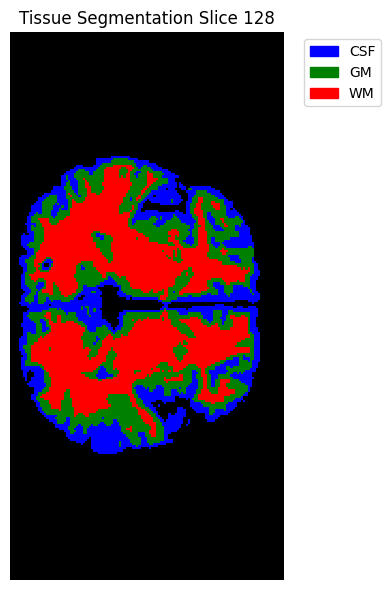

In [46]:
#-------------------------------------------------------------
# Importing required libraries
#-------------------------------------------------------------
import nibabel as nib               # For loading NIfTI medical image files
import matplotlib.pyplot as plt     # For plotting images
import numpy as np                  # For numerical operations
from matplotlib.colors import ListedColormap  # For creating custom color maps

#-------------------------------------------------------------
# Load the labeled NIfTI file based on the chosen system
#-------------------------------------------------------------
if x == '0':
    # If using RIU PC, set this path
    label_file = r"C:\\DeepAtlas\\OASIS_root\\IBSR_Img\\IBSR_01.nii"
else:
    # If using Local Laptop, set this path
    label_file = r"C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Img\IBSR_01.nii"

# Load the NIfTI image
label_img = nib.load(label_file)

# Get the image data as a float array for processing
label_data = label_img.get_fdata().astype(float)

#-------------------------------------------------------------
# Check unique labels present in the segmentation
#-------------------------------------------------------------
unique_labels = np.unique(label_data)
print("Unique labels in the image:", unique_labels)

#-------------------------------------------------------------
# Define a custom color map for visualizing tissues
#-------------------------------------------------------------
# Mapping: 0=black (background), 1=blue (CSF), 2=green (GM), 3=red (WM)
colors = ['black', 'blue', 'green', 'red']
custom_cmap = ListedColormap(colors)

#-------------------------------------------------------------
# Select the middle axial slice for visualization
#-------------------------------------------------------------
slice_index = label_data.shape[2] // 2    # Middle slice index along the z-axis
slice_data = label_data[:, :, slice_index] # Extracting that slice

#-------------------------------------------------------------
# Plotting the selected slice with custom color mapping
#-------------------------------------------------------------
plt.figure(figsize=(6, 6))  # Set plot size
plt.imshow(slice_data, cmap=custom_cmap, interpolation='nearest')  # Show slice with color map
plt.title(f"Tissue Segmentation Slice {slice_index}")  # Title indicating slice index
plt.axis('off')  # Hide axes ticks and labels

#-------------------------------------------------------------
# Adding a custom legend indicating tissue types
#-------------------------------------------------------------
import matplotlib.patches as mpatches
legend_labels = {
    1: "CSF",   # Cerebrospinal Fluid
    2: "GM",    # Gray Matter
    3: "WM"     # White Matter
}
# Create colored patches for legend based on the color map
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in legend_labels]

# Place legend outside the plot on the right
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent overlap and display the plot
plt.tight_layout()
plt.show()


# Mask Visualization

Unique labels in the image: [0. 1. 2. 3.]


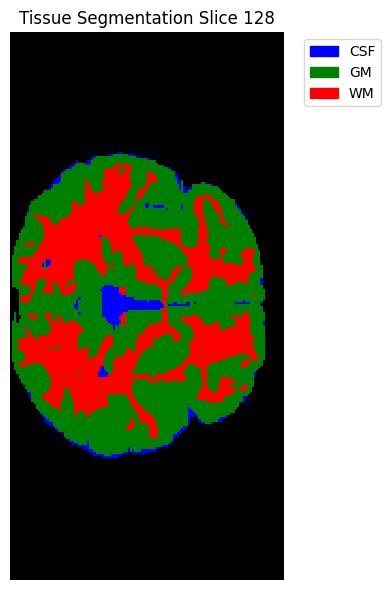

In [47]:
#-------------------------------------------------------------
# Import necessary libraries
#-------------------------------------------------------------
import nibabel as nib               # For loading NIfTI medical image files
import matplotlib.pyplot as plt     # For plotting images
import numpy as np                  # For numerical array operations
from matplotlib.colors import ListedColormap  # For creating a custom color map

#-------------------------------------------------------------
# Load the labeled NIfTI file based on the chosen system
#-------------------------------------------------------------
if x == '0':
    # If using RIU PC, set this path
    label_file = r"C:\\DeepAtlas\\OASIS_root\\IBSR_Mask\\IBSR_01.nii"
else:
    # If using Local Laptop, set this path
    label_file = r"C:\Users\Praful\OneDrive\Desktop\ChoorneSoch\OASIS_root\IBSR_Mask\IBSR_01.nii"

# Load the NIfTI file as an image object
label_img = nib.load(label_file)

# Extract the image data as a float array for processing
label_data = label_img.get_fdata().astype(float)

#-------------------------------------------------------------
# Check unique labels present in the segmentation mask
#-------------------------------------------------------------
unique_labels = np.unique(label_data)
print("Unique labels in the image:", unique_labels)
# This confirms which tissue classes exist in this mask (e.g. 0,1,2,3)

#-------------------------------------------------------------
# Define a custom color map for visualizing tissue segmentation
#-------------------------------------------------------------
# Mapping: 0=black (background), 1=blue (CSF), 2=green (GM), 3=red (WM)
colors = ['black', 'blue', 'green', 'red']
custom_cmap = ListedColormap(colors)

#-------------------------------------------------------------
# Select a slice (2D cross-section) to visualize
#-------------------------------------------------------------
slice_index = label_data.shape[2] // 2    # Middle slice index along z-axis
slice_data = label_data[:, :, slice_index] # Extract that slice data

#-------------------------------------------------------------
# Plotting the selected slice with the defined color mapping
#-------------------------------------------------------------
plt.figure(figsize=(6, 6))  # Set figure size for better visualization
plt.imshow(slice_data, cmap=custom_cmap, interpolation='nearest')  # Display the image slice
plt.title(f"Tissue Segmentation Slice {slice_index}")  # Set plot title indicating slice index
plt.axis('off')  # Hide axis ticks and labels for cleaner output

#-------------------------------------------------------------
# Creating a custom legend for tissue types
#-------------------------------------------------------------
import matplotlib.patches as mpatches  # For creating colored legend patches

# Define tissue labels corresponding to unique values
legend_labels = {
    1: "CSF",  # Cerebrospinal Fluid
    2: "GM",   # Gray Matter
    3: "WM"    # White Matter
}

# Create legend patches with corresponding colors and labels
patches = [mpatches.Patch(color=colors[i], label=legend_labels[i]) for i in legend_labels]

# Add the legend to the plot, placed outside to the right
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

#-------------------------------------------------------------
# Final plot adjustments and display
#-------------------------------------------------------------
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()          # Display the final plotted image
